In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm
from time import sleep
import random
import os

import re
import csv

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cluster import KMeans


import surprise as sur

from yellowbrick.regressor import ResidualsPlot

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
animecleaned =pd.read_csv('DL Data/anime_cleaned.csv')
usercleaned = pd.read_csv('DL Data/users_cleaned.csv')
data = pd.read_csv('DL Data/animelists_cleaned.csv')

In [3]:
animecleaned.set_index('title', drop=True,inplace=True)
animecleaned.drop(animecleaned[animecleaned['score']==0].index, inplace=True)
animecleaned.drop('Dokidoki Little Ooyasan', inplace=True)

In [4]:
unwanted_users=list(usercleaned[usercleaned.stats_mean_score==0]['username'])+ \
                list(usercleaned[usercleaned['stats_mean_score']==10]['username']) + \
                list(usercleaned[usercleaned['user_completed']<5]['username'])

In [5]:
#drop unwanted users from dataset
usercleaned =usercleaned.\
                drop(usercleaned[usercleaned['username'].isin(unwanted_users)].index)\
                .reset_index(drop=True)

In [6]:
#drop ratings from unwanted users and plan to watch ratings from dataset
data = data.drop(data[data['username'].isin(unwanted_users)].index).reset_index(drop=True)
data.drop(data[data['my_status']==6].index, inplace=True)

In [7]:
#As nulls were interpreted as 0, needed to clean watching,on-hold, and dropped of likely unrated shows
d= data[data['my_status'].isin([1,3,4])]
d= d[d['my_score']==0]
data.drop(d.index, inplace=True)
data = data[data['username'].map(data['username'].value_counts()) > 4]

In [8]:
#Plotting the anime average score per genre

In [9]:
def trysplit(x):
    try:
        return [y.strip() for y in x.split(',')]
    except:
        return ''

In [10]:
animecleaned['genre'] = animecleaned.genre.apply(trysplit)

In [11]:
mlb= MultiLabelBinarizer()

In [12]:
genre_dummies= pd.DataFrame(mlb.fit_transform(animecleaned['genre']),columns=mlb.classes_,
            index=animecleaned.index)

In [13]:
genred_anime = pd.merge(animecleaned, genre_dummies,left_index=True, right_index=True)

In [14]:
genre_scores=[]
for x in genre_dummies.columns:
    y= genred_anime[genred_anime[x]==1]['score'].mean()
    genre_scores.append([x,y])
genre_scores = sorted(genre_scores, key=lambda x: x[1], reverse=True)

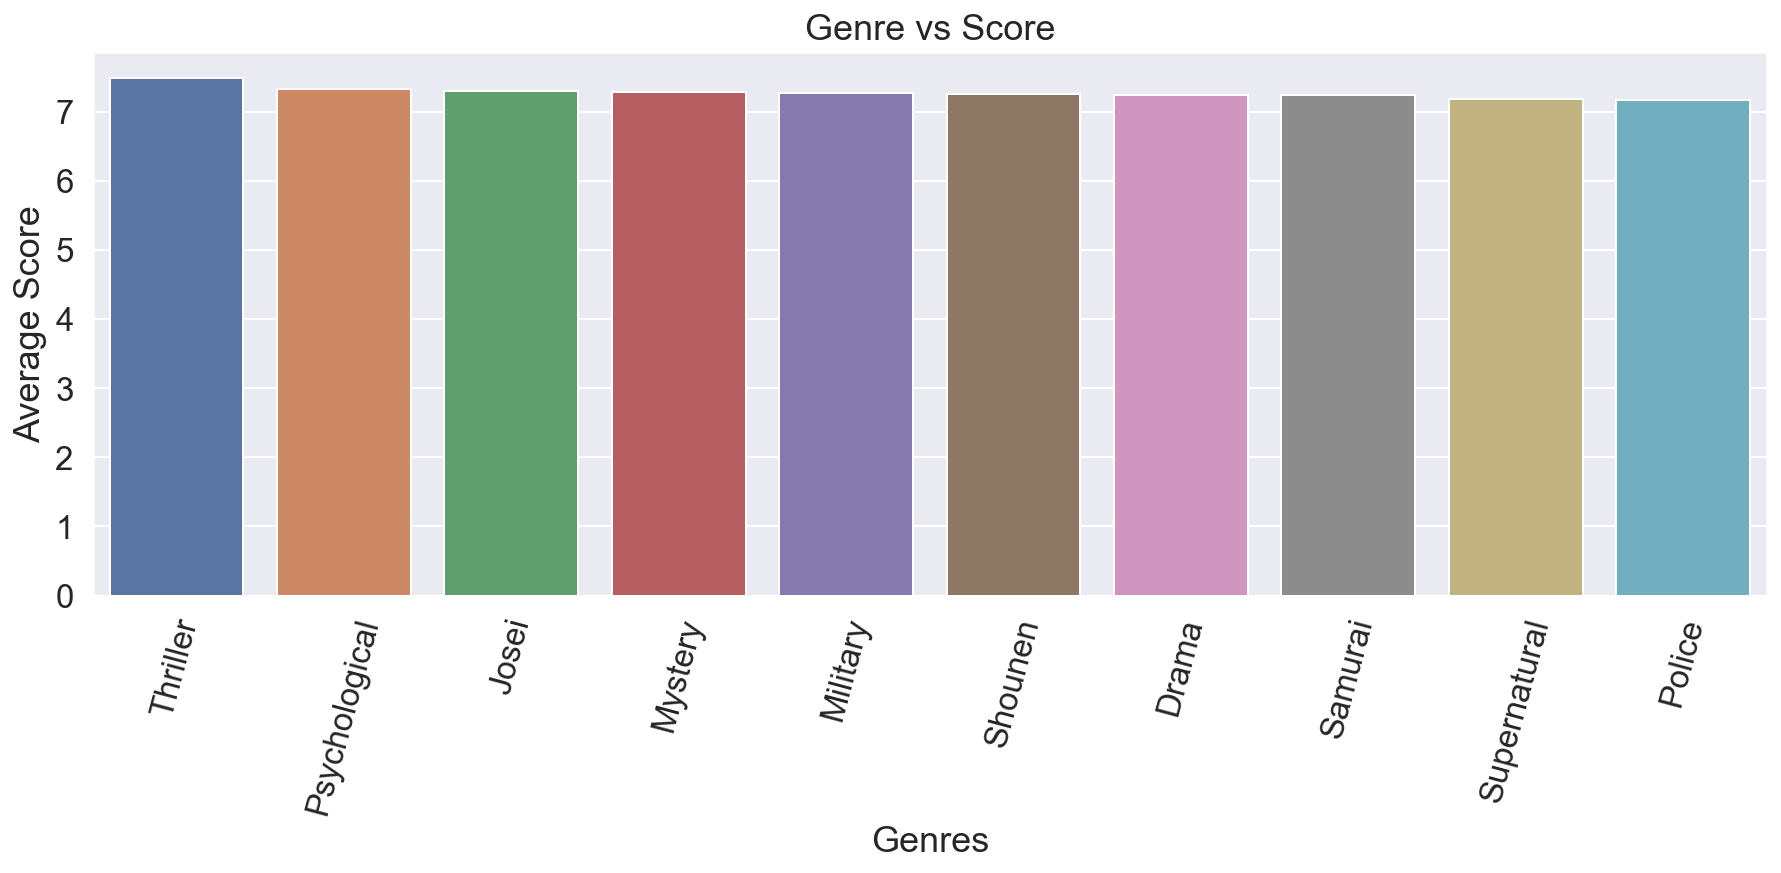

In [15]:
#plotting the top 10 rated genres
_sortgen = [x[0] for x in genre_scores][:10]
_sortscor = [y[1] for y in genre_scores][:10]
plt.figure(figsize=(15,5))
sns.barplot(x=_sortgen, y=_sortscor)
plt.xlabel('Genres')
plt.ylabel('Average Score')
plt.title('Genre vs Score') 
plt.xticks(rotation= 75) 
plt.show()

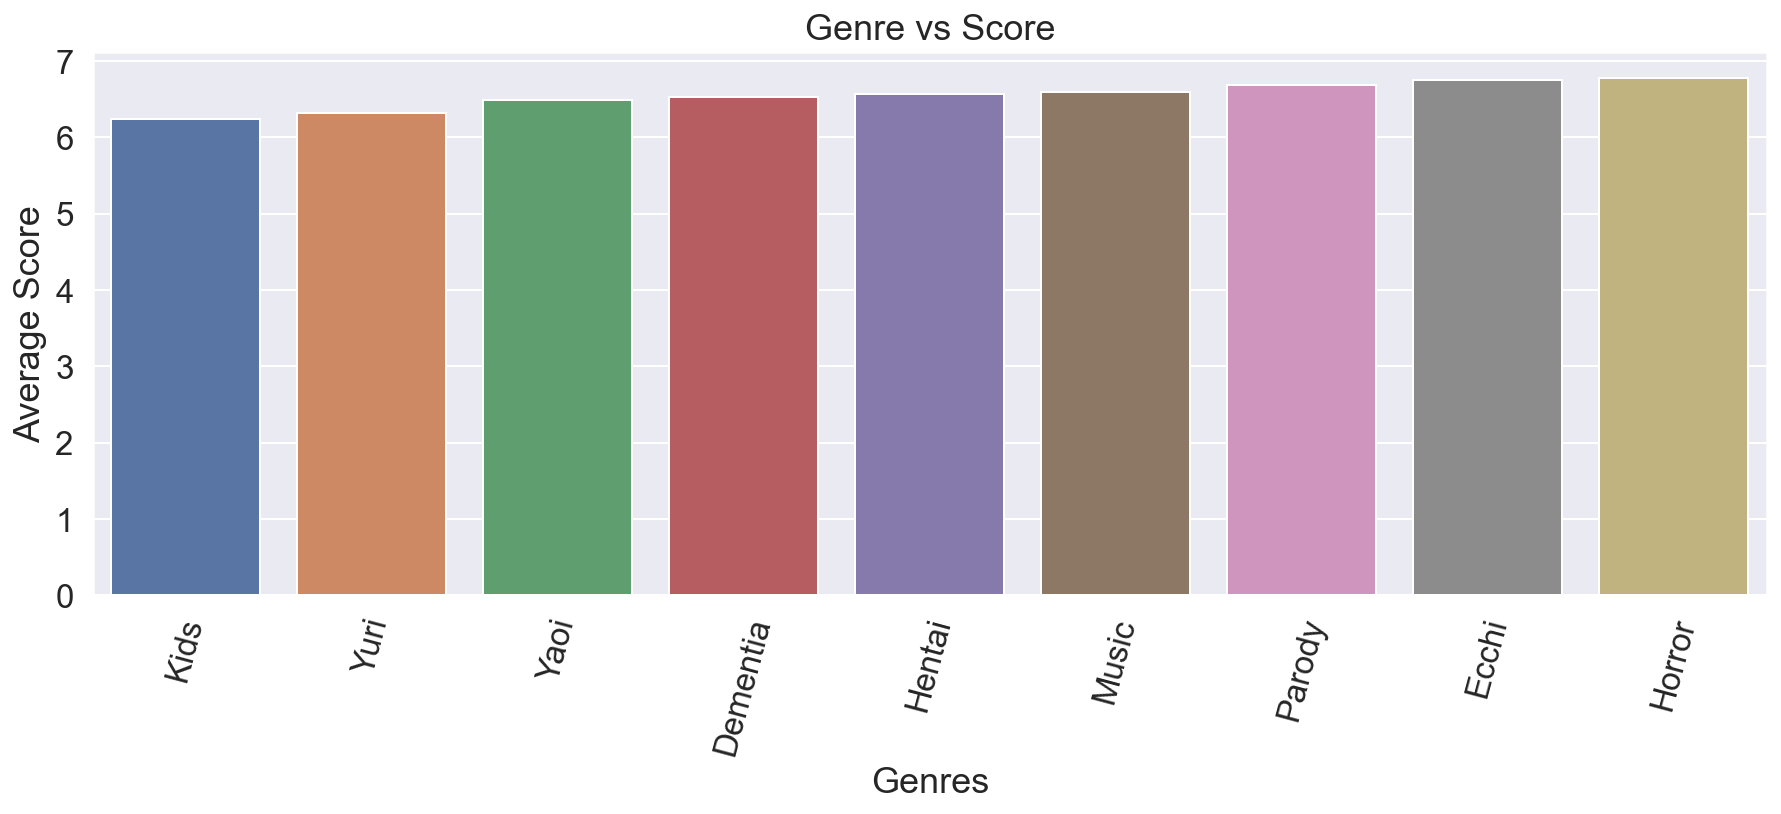

In [16]:
#plotting the bottom 10 rated genres
_rsortgen = [x[0] for x in genre_scores][-1:-10:-1]
_rsortscor = [y[1] for y in genre_scores][-1:-10:-1]
plt.figure(figsize=(15,5))
sns.barplot(x=_rsortgen, y=_rsortscor)
plt.xlabel('Genres')
plt.ylabel('Average Score')
plt.title('Genre vs Score') 
plt.xticks(rotation= 75) 
plt.show()

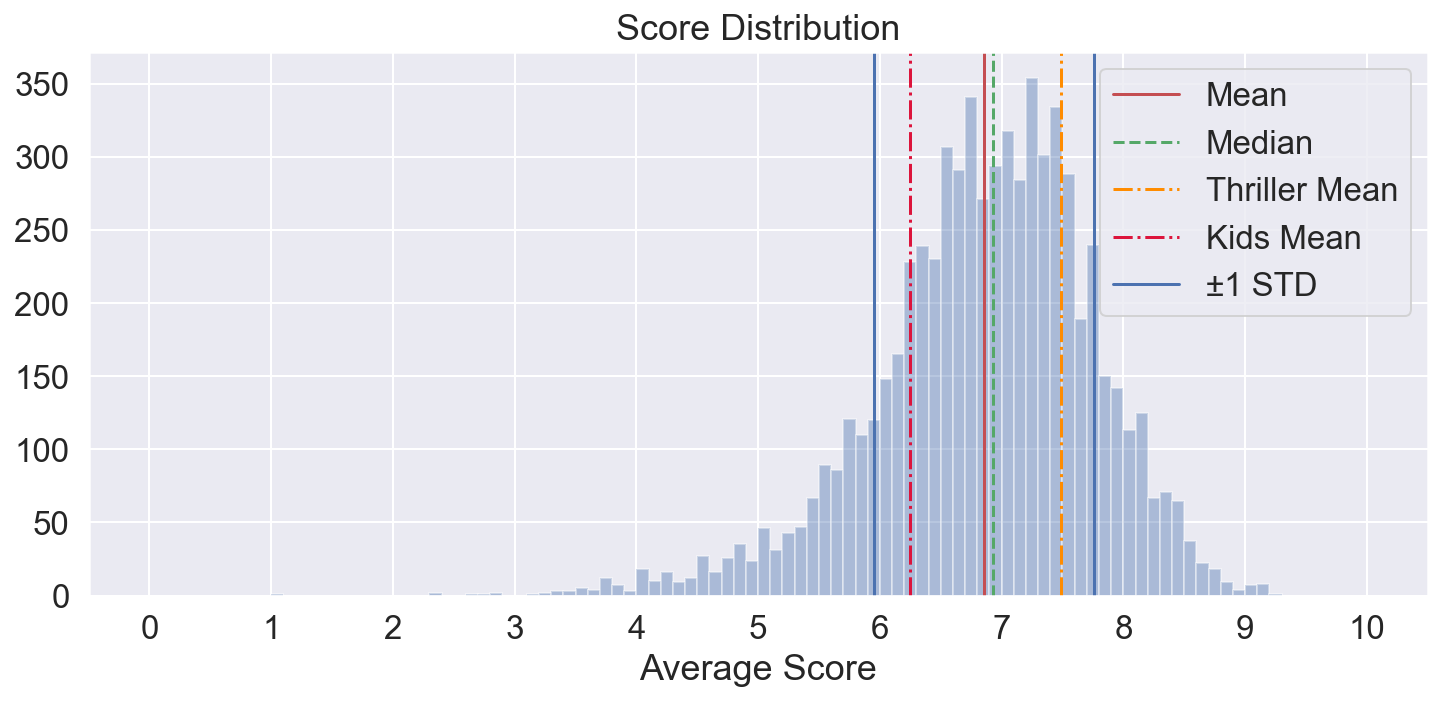

In [17]:
#Plotting the rating distributions

mean= animecleaned['score'].mean()
median= animecleaned['score'].median()
std= animecleaned['score'].std()


fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(animecleaned[['score']],kde=False, bins=np.linspace(0,10,101), ax=ax);
plt.xlabel('Average Score')
plt.title('Score Distribution') 
ax.axvline(x=mean, color='r', linestyle='-')
ax.axvline(x=median, color='g', linestyle='--')
ax.axvline(x=genre_scores[0][1], color='#FF8C00', linestyle='-.')
ax.axvline(x=genre_scores[-1][1], color='#DC143C', linestyle='-.')
ax.axvline(x=mean+std, color='b', linestyle='-')
ax.axvline(x=mean-std, color='b', linestyle='-')



plt.legend({'Mean':mean,'Median':median, f'{genre_scores[0][0]} Mean':genre_scores[0][1],
            f'{genre_scores[-1][0]} Mean': genre_scores[-1][1], '±1 STD': mean+std})
plt.xticks(range(11));

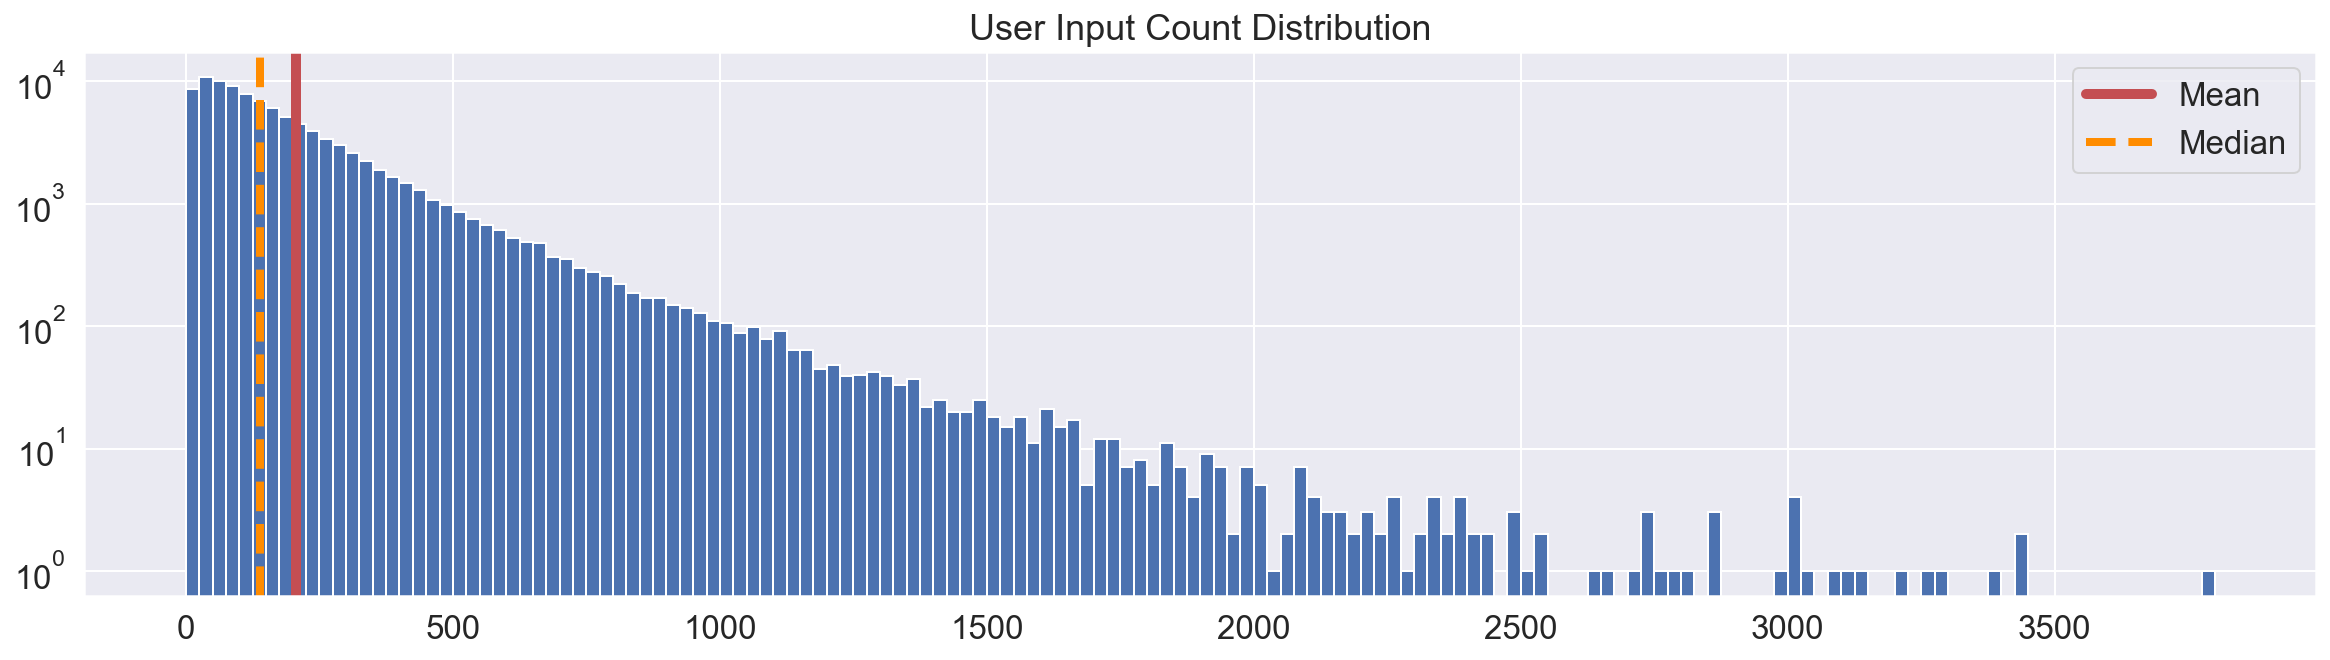

In [18]:
#plotting the distribution of user rating counts
user_counts= data.groupby('username')['my_score'].count().values
user_counts
fig,ax= plt.subplots(figsize=(20,5))
plt.hist(user_counts, bins=np.linspace(0,3800,(3800//25)+1 ), log=True)
plt.title('User Input Count Distribution')
ax.axvline(x=user_counts.mean(), color='r', linestyle='-', lw=5)
ax.axvline(x=np.median(user_counts), color='#FF8C00', linestyle='--', lw=4)

plt.legend({'Mean':mean,'Median':median});

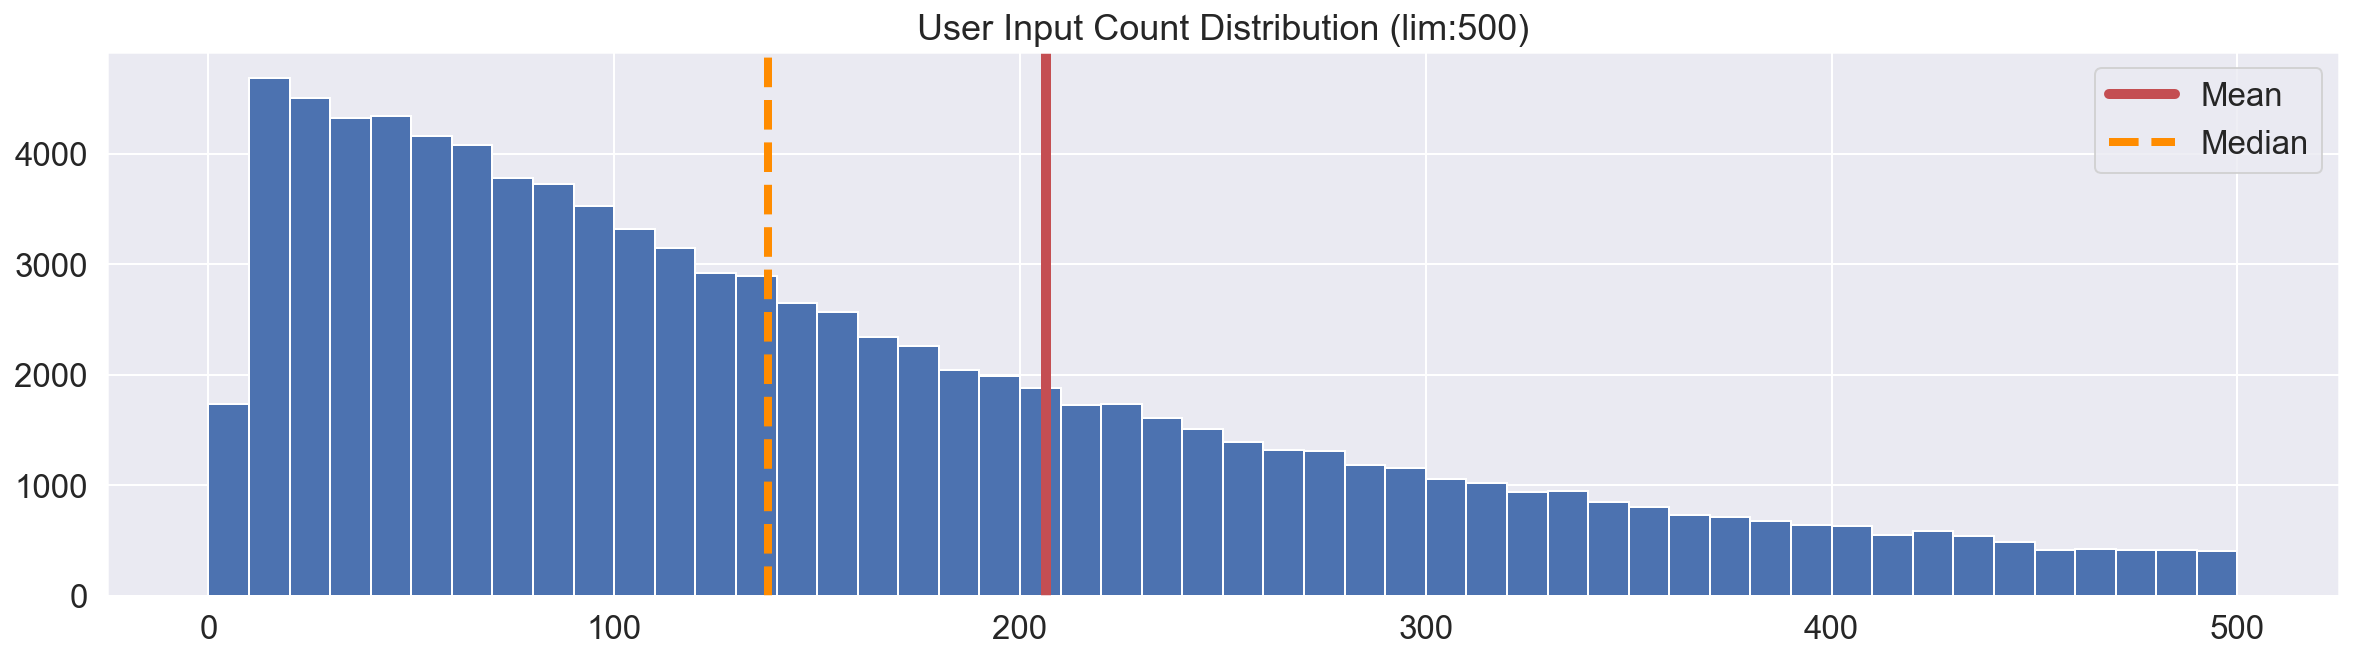

In [19]:
fig,ax= plt.subplots(figsize=(20,5))
plt.hist(user_counts, bins=np.linspace(0,500,(500//10)+1 ))
plt.title('User Input Count Distribution (lim:500)')
ax.axvline(x=user_counts.mean(), color='r', linestyle='-', lw=5)
ax.axvline(x=np.median(user_counts), color='#FF8C00', linestyle='--', lw=4)

plt.legend(['Mean','Median']);

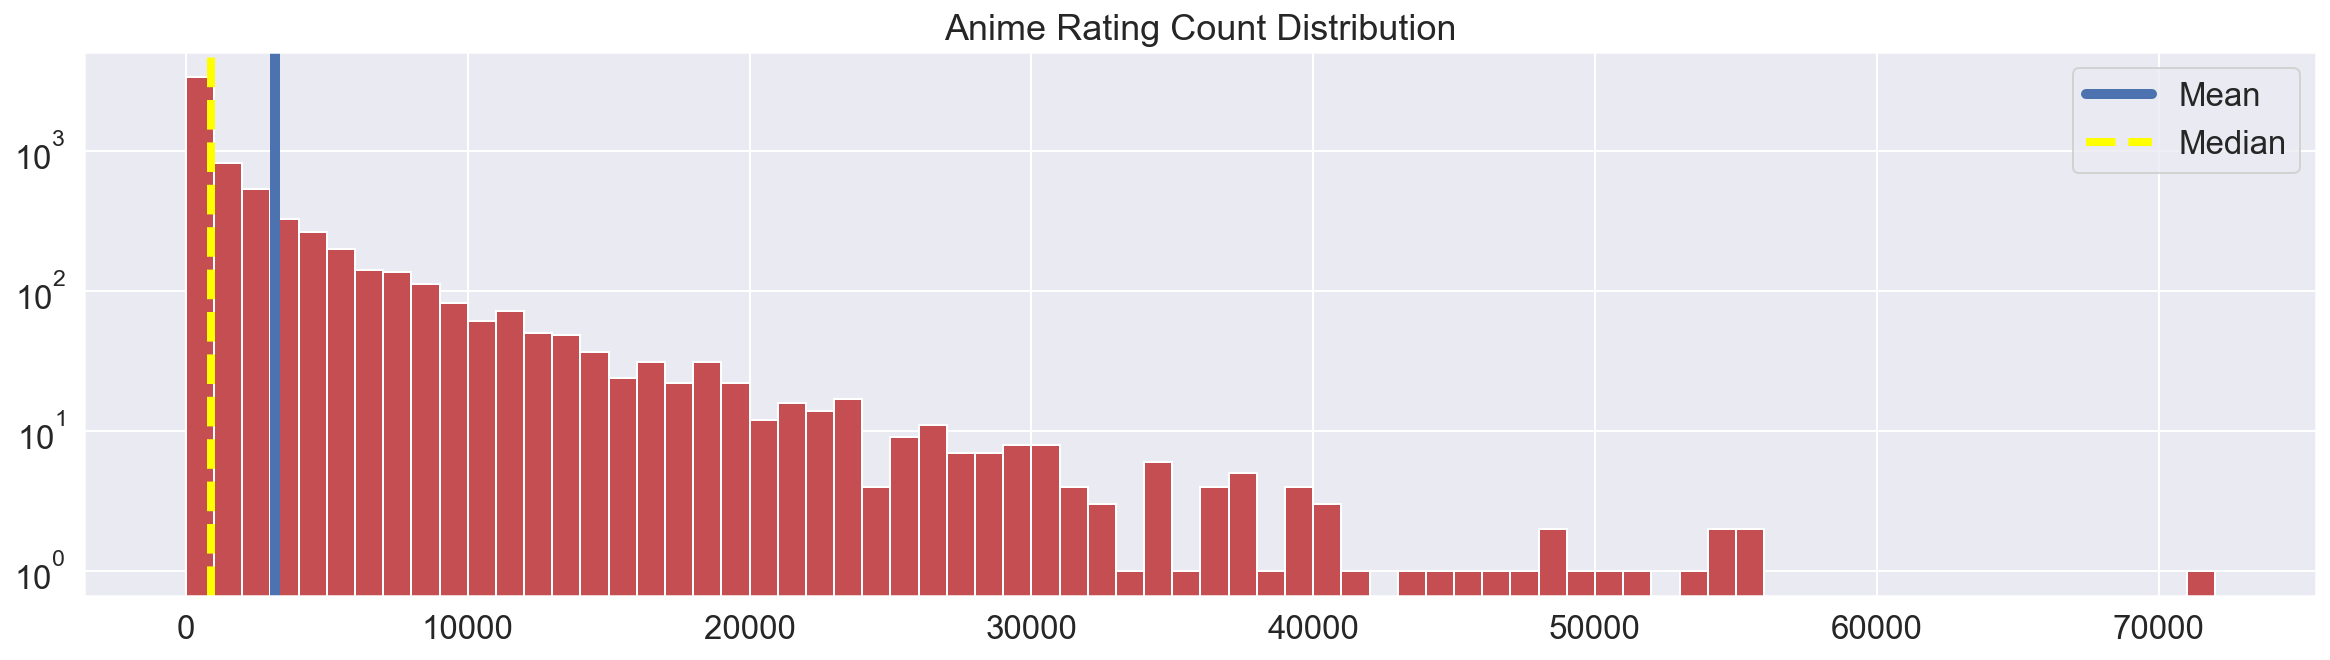

In [20]:
#Plotting the distribution of anime rating counts
anime_counts= data.groupby('anime_id')['my_score'].count().values
fig,ax= plt.subplots(figsize=(20,5))
plt.hist(anime_counts, bins=np.linspace(0,72000,(72000//1000)+1 ), log=True, color='r')
plt.title('Anime Rating Count Distribution')
ax.axvline(x=anime_counts.mean(), color='b', linestyle='-', lw=5)
ax.axvline(x=np.median(anime_counts), color='#FFFF00', linestyle='--', lw=4)


plt.legend(['Mean','Median']);

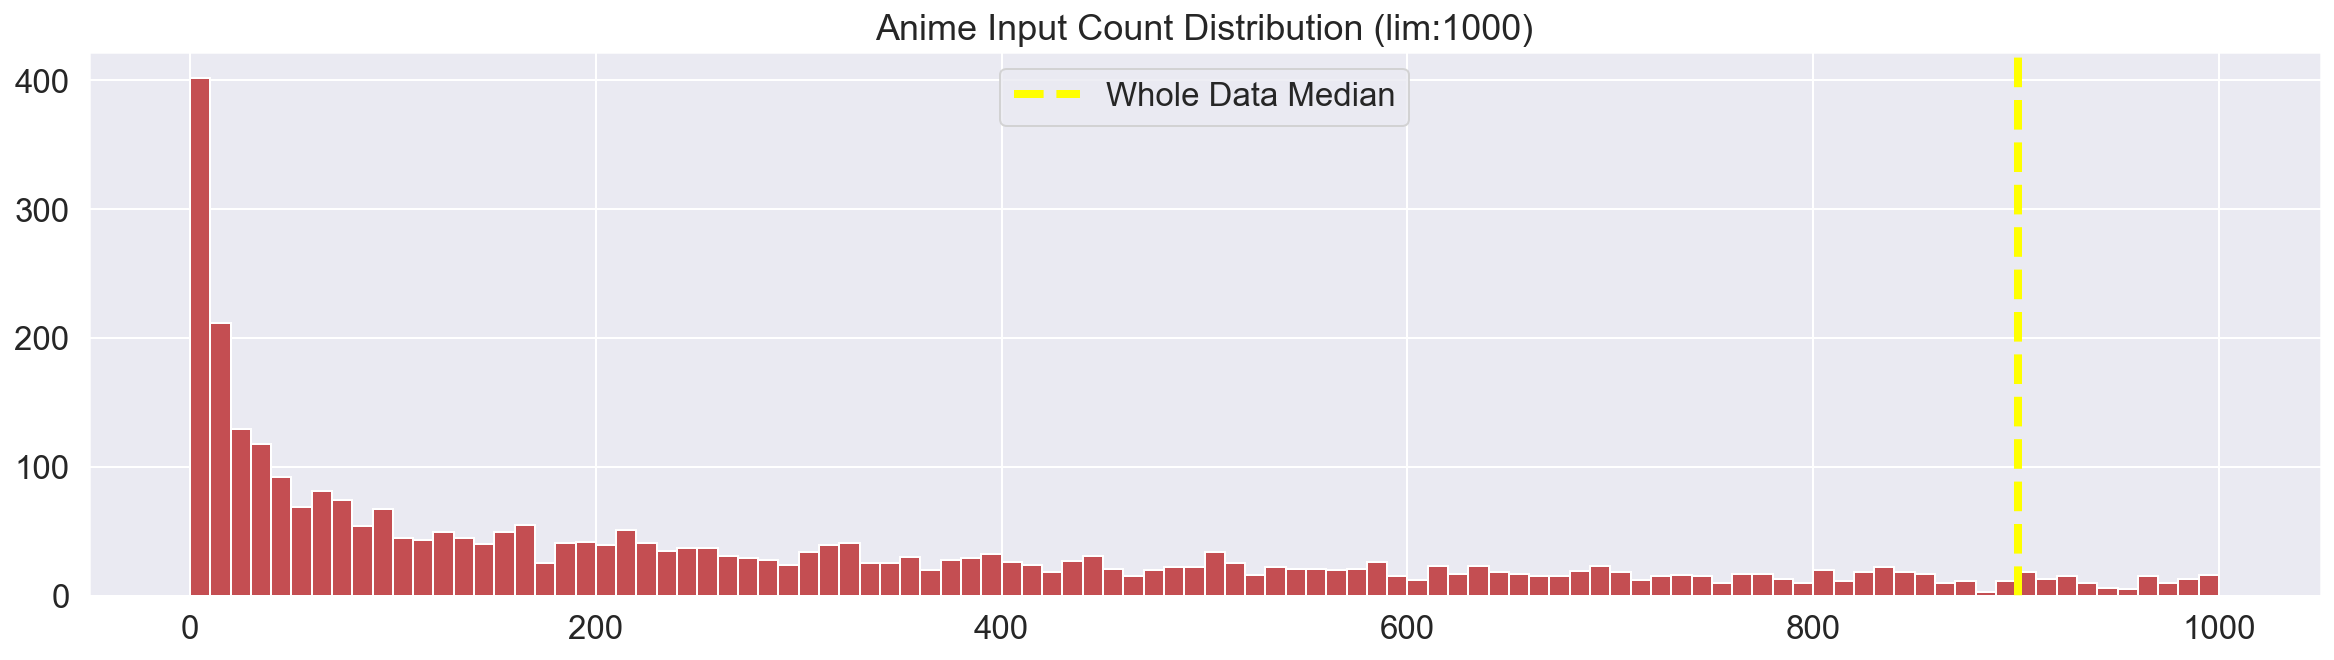

In [21]:
fig,ax= plt.subplots(figsize=(20,5))
plt.hist(anime_counts, bins=np.linspace(0,1000,(1000//10)+1), color='r')
plt.title('Anime Input Count Distribution (lim:1000)')
ax.axvline(x=np.median(anime_counts), color='#FFFF00', linestyle='--', lw=4)

plt.legend(['Whole Data Median']);

In [22]:
#build full set of dummies for the shows

In [23]:
mlb= MultiLabelBinarizer()

In [24]:
animecleaned['producer']= animecleaned.producer.apply(trysplit)
producer_dummies= pd.DataFrame(mlb.fit_transform(animecleaned['producer']),columns=mlb.classes_,
            index=animecleaned.index)


In [25]:
animecleaned['studio']= animecleaned.studio.apply(trysplit)
studio_dummies= pd.DataFrame(mlb.fit_transform(animecleaned['studio']),columns=mlb.classes_,
            index=animecleaned.index)

In [26]:
animecleaned['source']= animecleaned.source.apply(trysplit)
source_dummies= pd.DataFrame(mlb.fit_transform(animecleaned['source']),columns=mlb.classes_,
            index=animecleaned.index)

In [27]:
animecleaned['aired_from_year']= animecleaned.aired_from_year.apply(lambda x: [x])
year_dummies= pd.DataFrame(mlb.fit_transform(animecleaned['aired_from_year']),\
                    columns=mlb.classes_,
            index=animecleaned.index)

In [29]:
#drop underrepresented dummies
for col in genre_dummies.columns:
    if genre_dummies[col].sum()<50:
        genre_dummies.drop(columns=[col],inplace=True)

In [30]:
for col in producer_dummies.columns:
    if producer_dummies[col].sum()<50:
        producer_dummies.drop(columns=[col],inplace=True)

In [31]:
for col in studio_dummies.columns:
    if studio_dummies[col].sum()<50:
        studio_dummies.drop(columns=[col],inplace=True)

In [32]:
for col in source_dummies.columns:
    if source_dummies[col].sum()<50:
        source_dummies.drop(columns=[col],inplace=True)

In [33]:
for col in year_dummies.columns:
    if year_dummies[col].sum()<50:
        year_dummies.drop(columns=[col],inplace=True)

In [34]:
full_dummies= genre_dummies.merge(producer_dummies, left_index=True,right_index=True)\
            .merge(studio_dummies,left_index=True,right_index=True)\
            .merge(source_dummies,left_index=True,right_index=True)\
            .merge(year_dummies,left_index=True,right_index=True)\
            .merge(animecleaned['anime_id'], left_index=True,right_index=True)

In [35]:
score_predictor= animecleaned[['anime_id','score']].merge(full_dummies,
                                   on='anime_id', how='left')
score_predictor.drop(columns=['anime_id'], inplace=True)
score_predictor.index= animecleaned.index

In [36]:
#Genre-Score Matrix is ready so we can get to modelling

In [37]:
y= score_predictor.pop('score')

In [38]:
scaler= StandardScaler()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(score_predictor, y, test_size=0.2)
Xtrain= scaler.fit_transform(X_train)
Xtest= scaler.transform(X_test)

In [81]:
#These hyperparameters were found with code that is now crashing, will update once issue is resolved...
nnet = MLPRegressor(hidden_layer_sizes=(8,8,8,8,8), solver='lbfgs',
                    activation='identity', max_iter=100000, 
                    alpha=10**(-12))
nnet.fit(Xtrain,y_train)
nn=[
    nnet.score(Xtrain,y_train),
    cross_val_score(nnet, Xtrain, y_train,cv=5).mean(),
    nnet.score(Xtest,y_test)
]

In [87]:
#Gridsearching on Elastic net
param_grid={"alpha":np.logspace(-3,3,7), 'l1_ratio': np.linspace(0.0001,1,11)}

enet=ElasticNet()
grid_en=GridSearchCV(enet,param_grid,cv=5,verbose=True, n_jobs=1)
grid_en.fit(Xtrain,y_train)
print(grid_en.best_params_)
en_mod= grid_en.best_estimator_


en_mod.fit(Xtrain,y_train)
en=[
    en_mod.score(Xtrain,y_train),
    cross_val_score(en_mod, Xtrain, y_train,cv=5).mean(),
    en_mod.score(Xtest,y_test)
]


Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 385 out of 385 | elapsed:    9.5s finished


{'alpha': 0.1, 'l1_ratio': 0.0001}


In [94]:
#Gridsearching on Decision Tree Regressor

dtr = DecisionTreeRegressor()
param_grid={"min_samples_split":[2,3,4,5,10], 'max_depth':[None, 5,6,10,11],
           'max_features':[None,50,100]}


grid_dtr=GridSearchCV(dtr,param_grid,cv=5, verbose=True, n_jobs=1)
grid_dtr.fit(Xtrain,y_train)

dtr_mod= grid_cv.best_estimator_
print("tuned hpyerparameters :(best parameters) ",grid_cv.best_params_)



dtr_mod.fit(Xtrain,y_train)
dtr=[
    dtr_mod.score(Xtrain,y_train),
    cross_val_score(dtr_mod, Xtrain, y_train,cv=5).mean(),
    dtr_mod.score(Xtest,y_test)
]

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


tuned hpyerparameters :(best parameters)  {'max_depth': 11, 'max_features': 100, 'min_samples_split': 10}


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:    8.9s finished


In [104]:
#Fitting Linear Regression model on unstanderdised data
lr_mod= LinearRegression()
lr_mod.fit(X_train,y_train)
lr=[
    lr_mod.score(X_train,y_train),
    cross_val_score(lr_mod, X_train, y_train,cv=5).mean(),
    lr_mod.score(X_test,y_test)
]

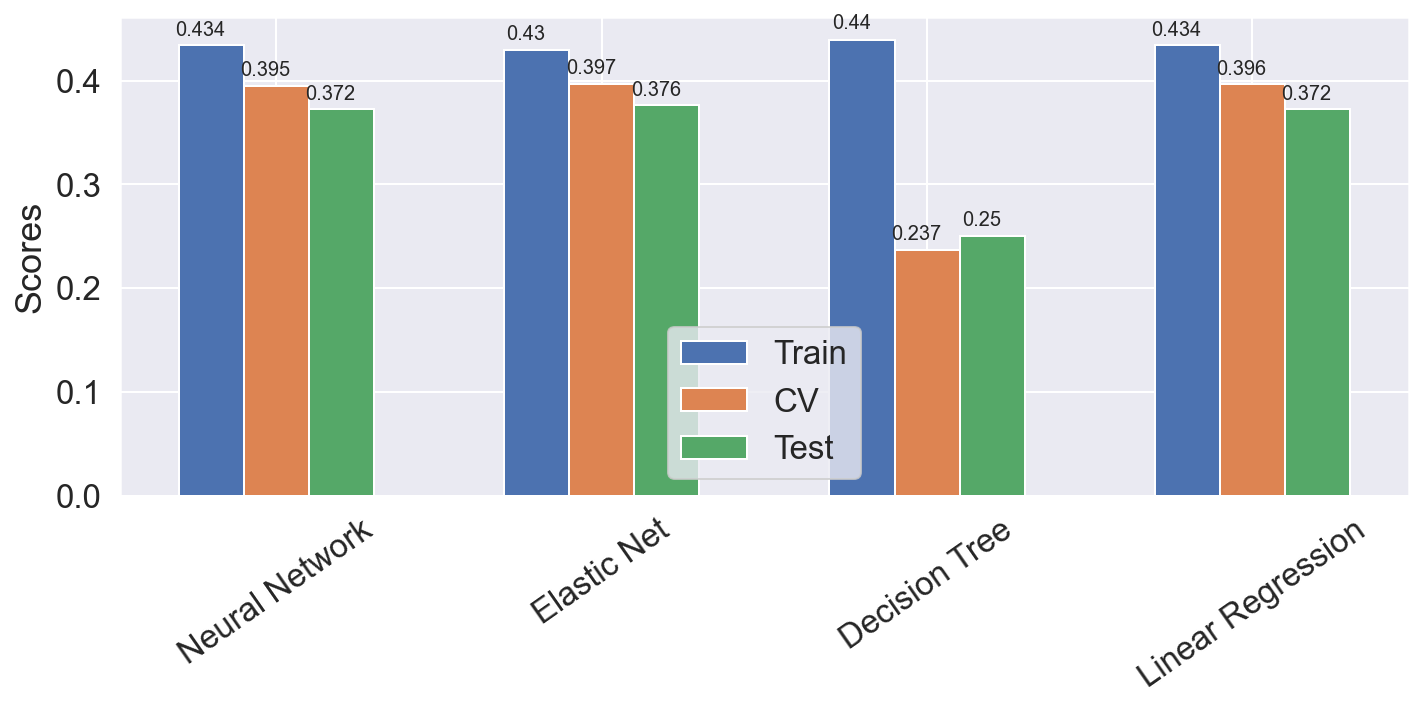

In [105]:
#Graphing the various scores

labels = ['Neural Network', 'Elastic Net', 'Decision Tree', 'Linear Regression']
models= [nn, en, dtr, lr]
trainscores = [x[0] for x in models]
cvscores= [x[1] for x in models]
testscores = [x[2] for x in models]


x = np.arange(len(labels))  # the label locations
width = 0.2# the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width, trainscores, width, label='Train')
rects2 = ax.bar(x, cvscores, width, label='CV')
rects3 = ax.bar(x + width, testscores, width, label='Test')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=35)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = np.round(rect.get_height(),3)
        if height>0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
        else:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(0, -9), 
                        textcoords="offset points",
                        ha='center', va='bottom')            

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

In [106]:
#Making a DataFrame of the Linear Regression variables as they are most interpretable
df= pd.DataFrame(lr_mod.coef_, index=score_predictor.columns)
df['square']= df[0]**2
df.sort_values('square', ascending=False, inplace=True)
df.drop(columns='square', inplace=True)
df.columns=['variable']

In [117]:
#cleaning up the coefficent names
important_coefs_20 = ['DLE',
 'Studio Ghibli',
 'Picture book',
 'Music (Source)',
 'Kyoto Animation',
 'Sunrise',
 '2009',
 'Warner Bros.',
 '2008',
 'ufotable',
 'NNS',
 'Nippon Ani.',
 '2010',
 '2007',
 'Shaft',
 'Hentai',
 'Aniplex',
 'Toho',
 'TOHO Ani.',
 'NHK']


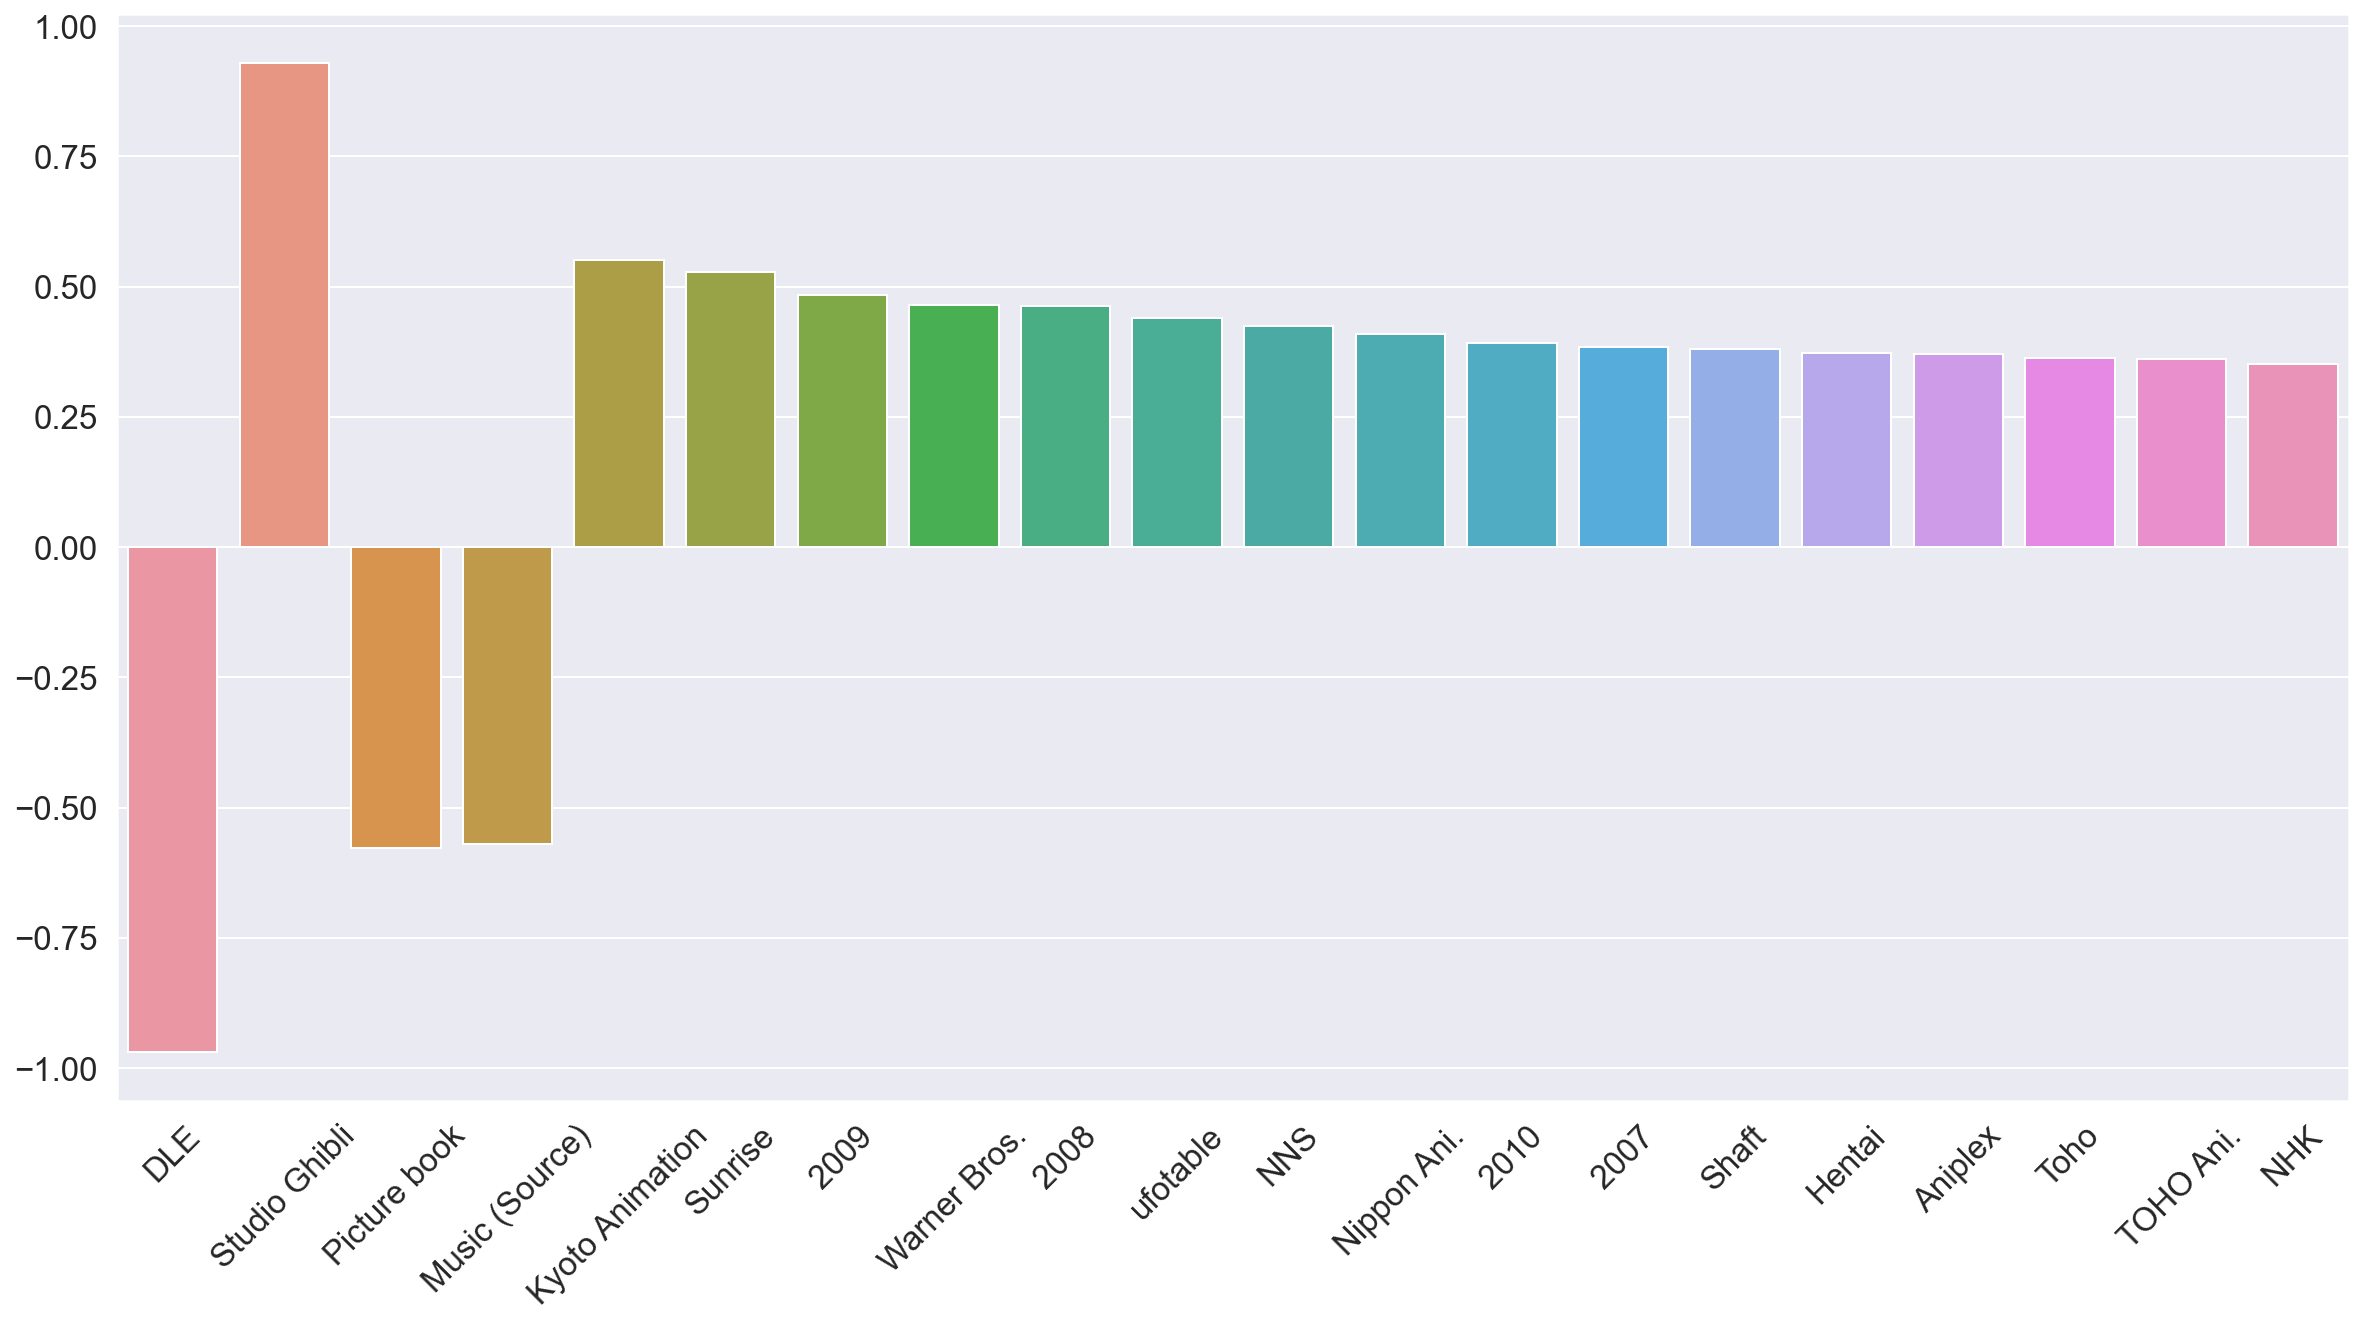

In [126]:
#Plotting the top 20 coefs
plt.figure(figsize=(20,10))
sns.barplot(important_coefs_20,df.variable[:20])
plt.xticks(rotation=45)
plt.ylabel('');

In [171]:
#creating a data frame of the predictions, scores, and residuals
predictions= lr_mod.predict(X_train)
pred_v_score =pd.DataFrame(columns=['Prediction', 'Score'], index=X_train.index)
pred_v_score['Prediction']= predictions
pred_v_score['Score']= y_train.values
pred_v_score['Resid']= pred_v_score['Prediction']- pred_v_score['Score']
pred_v_score.sort_values('Prediction', ascending=False, inplace=True)

In [172]:
test_predictions= lr_mod.predict(X_test)
test_pred_v_score =pd.DataFrame(columns=['Prediction', 'Score'], index=X_test.index)
test_pred_v_score['Prediction']= test_predictions
test_pred_v_score['Score']= y_test.values
test_pred_v_score['Resid']= test_pred_v_score['Prediction']- test_pred_v_score['Score']
test_pred_v_score.sort_values('Prediction', ascending=False, inplace=True)

In [173]:
full_pred_v_score= pred_v_score.append(test_pred_v_score)

In [174]:
full_pred_v_score.sort_values('Prediction', ascending=False, inplace=True)

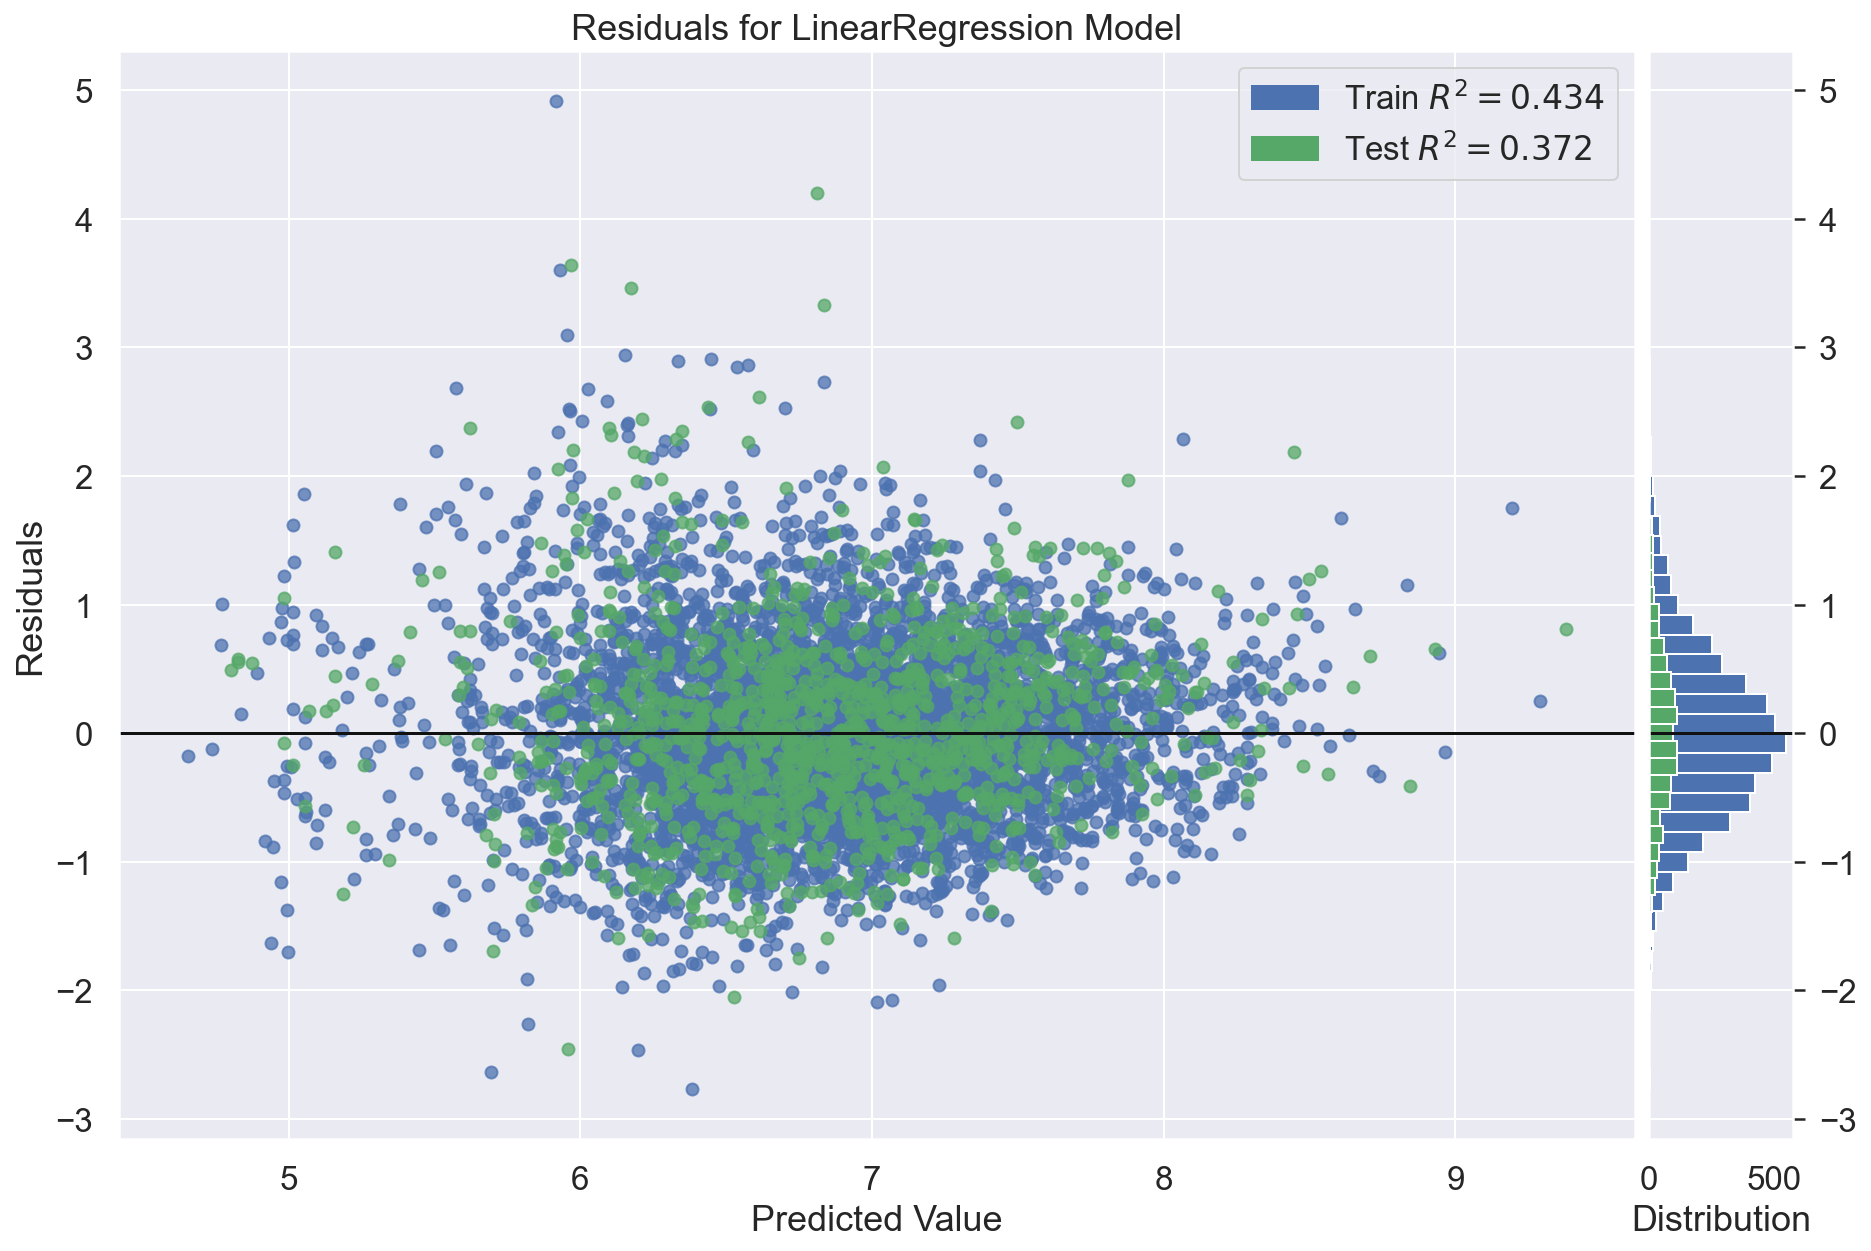

In [169]:
#plotting residuals
plt.figure(figsize=(15,10))
visualizer = ResidualsPlot(lr_mod)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

In [177]:
full_pred_v_score.head(20)

,Prediction,Score,Resid
title,,,
Gintama Movie 1: Shinyaku Benizakura-hen,9.377981,8.57,0.807981
Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,9.291235,9.04,0.251235
Fullmetal Alchemist: The Sacred Star of Milos,9.194843,7.44,1.754843
Gintama&#039;,8.963205,9.11,-0.146795
InuYasha: Kanketsu-hen,8.942804,8.32,0.622804
Omoide no Marnie,8.931158,8.28,0.651158
Fullmetal Alchemist: Brotherhood,8.843123,9.25,-0.406877
InuYasha: Toki wo Koeru Omoi,8.834520,7.68,1.154520
Gintama&#039;: Enchousen,8.736508,9.07,-0.333492


In [178]:
#building a bias frame to cluster users and predict gender

In [181]:
reccomendation_data= data[['username','anime_id','my_score']]

In [186]:
#establish baseline predictions for each rating
reader = sur.Reader(rating_scale=(0, 10))
data_1 = sur.Dataset.load_from_df(
    reccomendation_data, reader)


trainset = data_1.build_full_trainset()
trainset_build = trainset.build_testset()
bo= sur.BaselineOnly()
bo.fit(trainset)
predictions = bo.test(trainset_build)

#optional alert
os.system("say 'ni ko ni ko ni'") 

Estimating biases using als...


0

In [202]:
#add the residuals for the baseline to the data
data['unexplained_var']= [x.r_ui - x.est for x in predictions]

In [209]:
#create frame with user, residual, and previously established dummies of anime as well as a dummy for if the anime is popular
def itsover100(x):
    if x<100:
        return 1
    else:
        return 0
popular_dummy = animecleaned.popularity.apply(itsover100)
full_dummies_pop = pd.merge(full_dummies, popular_dummy, left_index=True, right_index=True)

In [220]:
genre_bias_frame =[]

In [224]:
usernames = data.username.unique()
biases= list(full_dummies_pop.columns)
biases.remove('anime_id')

In [227]:
unexplained_variance_data =data[['username','anime_id','unexplained_var']]

In [229]:
count=0
biasframe=[]
for username in tqdm(usernames):
    count+=1
    y= unexplained_variance_data[unexplained_variance_data['username']==username]
    y= pd.merge(y, full_dummies_pop, on='anime_id')
    
    biaslist= [username]
    for i in biases:
        meanbias= y[y[i]==1]['unexplained_var'].mean()
        biaslist.append(meanbias)
        
    biasframe.append(biaslist)
    if count%300 ==0:
        with open("bias_frame.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(biasframe)

with open("bias_frame.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(biasframe)

100%|██████████| 101494/101494 [29:04:46<00:00,  1.03s/it]   


In [234]:
bias_df = pd.DataFrame(biasframe, columns=['username']+list(biases))

In [242]:
bias_df.fillna(value=0, inplace=True)
bias_df.set_index('username', drop=True, inplace=True)

In [243]:
bias_df.head()

,Action,Adventure,Comedy,Demons,Drama,Ecchi,Fantasy,Game_x,Harem,Hentai,...,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,popularity
username,,,,,,,,,,,,,,,,,,,,,
karthiga,0.852951,0.585247,0.135557,1.010655,-0.235312,0.592472,0.270858,-1.377423,0.427525,0.000000,...,-0.370756,-0.344962,0.441892,-1.130898,0.000000,0.000000,0.000000,0.000000,0.000000,0.568089
Damonashu,-0.306284,-0.282358,-0.234431,-0.996030,0.201221,-0.156039,-0.195792,-0.132555,-0.661999,0.000000,...,1.229334,-0.456394,0.485427,1.395809,-0.365481,-0.173019,0.669745,0.000000,0.000000,-0.149977
bskai,-0.130468,-0.102616,0.198103,-0.853212,-0.261317,0.823713,-0.229782,0.906082,0.981727,0.000000,...,0.136283,0.942256,0.000000,0.000000,-0.599828,0.000000,0.000000,0.000000,0.000000,-0.524245
Slimak,0.028349,-0.132757,0.216603,0.163788,0.065821,0.472007,-0.032301,0.140665,0.526067,0.000000,...,0.001332,0.325711,0.335761,0.068372,-0.150928,0.042231,0.434809,-0.100044,0.000000,0.127208
MistButterfly,0.140816,0.014595,-0.006446,0.403093,0.119495,-0.305115,0.055830,0.238714,-0.349239,-0.813374,...,0.107068,-0.004090,0.109482,0.098297,0.001696,0.043175,0.254844,0.205321,-0.009725,1.256750


In [ ]:
x_list = [2,3,4,5,8,13,21,100,400,1600,6000,20000]
y_list= []
for x in tqdm(x_list):
    model = KMeans(n_clusters=x, n_jobs=-1)
    model.fit(bias_df)
    labels = model.labels_
    y_list.append(metrics.silhouette_score(bias_df, labels))
#optional alert
os.system(f"say 'ki ni na ri ma su'") 

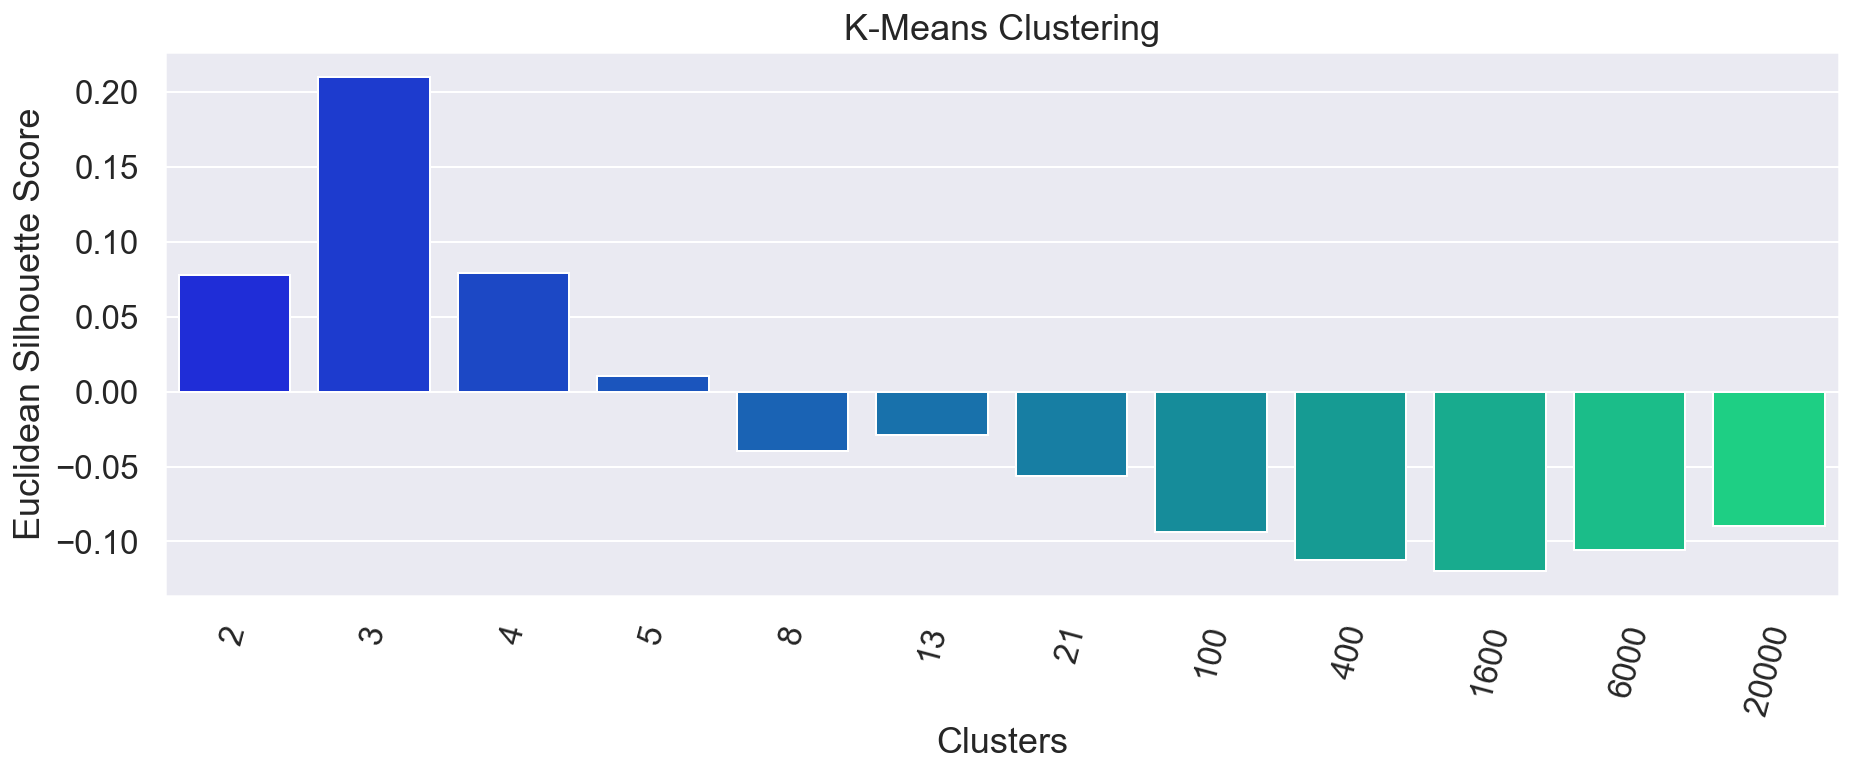

In [255]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_list, y=y_list, palette='winter')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Silhouette Score')
plt.title('K-Means Clustering') 
plt.xticks(rotation= 75) 
plt.show()

In [250]:
#using the bias dataframe to predict gender
#due to a serious inbalance in classes, we will prediciting whether a user is male or not

In [257]:
genderlist= usercleaned[['username','gender']]

def genderer(x):
    if x == 'Male':
        return 1
    else:
        return 0
    
genderlist['labels']=usercleaned['gender'].apply(genderer)

<ipython-input-257-fd31495c78fb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genderlist['labels']=usercleaned['gender'].apply(genderer)


In [260]:
gender_bias_df= pd.merge(genderlist,bias_df,
                         left_on='username', right_index=True)
gender_bias_df.drop(columns=['username','gender'], inplace=True)

In [264]:
#create a test train split, and evaluate different models
y= gender_bias_df.pop('labels')
X_train, X_test, y_train, y_test = train_test_split(
    gender_bias_df, y, test_size=0.33, random_state=42)

In [271]:
Xtrain= scaler.fit_transform(X_train)
Xtest= scaler.transform(X_test)

In [274]:
#Gridsearching on Decision Tree Regressor

clf = MLPClassifier(solver='adam',
                        alpha=0.06,
                        random_state=42,
                        batch_size=500,
                        max_iter=5000)

param_grid={'activation':['logistic', 'tanh', 'relu'],
            'hidden_layer_sizes':[(8,8,8,8,8), (50,100,50),(30,30,30,30)]}


grid_mlpc=GridSearchCV(clf,param_grid,cv=5, verbose=True, n_jobs=1)
grid_mlpc.fit(Xtrain,y_train)

mlpc_mod= grid_mlpc.best_estimator_
print("tuned hpyerparameters :(best parameters) ",grid_mlpc.best_params_)



mlpc_mod.fit(Xtrain,y_train)
mlpc=[
    mlpc_mod.score(Xtrain,y_train),
    cross_val_score(mlpc_mod, Xtrain, y_train,cv=5).mean(),
    mlpc_mod.score(Xtest,y_test)
]


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 45.6min finished


tuned hpyerparameters :(best parameters)  {'activation': 'tanh', 'hidden_layer_sizes': (8, 8, 8, 8, 8)}


In [279]:
#Gridsearching on Elastic net
param_grid=[{"penalty":['elasticnet'],
            'C':np.logspace(-2,2,100),
            'l1_ratio': np.linspace(0.0001,1,11)},{'penalty':['none']}]

lr=LogisticRegression(solver='saga')
grid_lr=GridSearchCV(lr,param_grid,cv=5,verbose=True, n_jobs=1)
grid_lr.fit(Xtrain,y_train)
print(grid_lr.best_params_)
lr_mod= grid_lr.best_estimator_


lr_mod.fit(Xtrain,y_train)
lrc=[
    lr_mod.score(Xtrain,y_train),
    cross_val_score(lr_mod, Xtrain, y_train,cv=5).mean(),
    lr_mod.score(Xtest,y_test)
]



Fitting 5 folds for each of 1101 candidates, totalling 5505 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5505 out of 5505 | elapsed: 154.4min finished


{'C': 0.10235310218990264, 'l1_ratio': 0.0001, 'penalty': 'elasticnet'}


In [281]:
#Gridsearching on Decision Tree Classifier

dtc = DecisionTreeClassifier()
param_grid={"min_samples_split":[2,3,4,5,10], 'max_depth':[None, 5,6,10,11],
           'max_features':[None,50,100]}


grid_dtc=GridSearchCV(dtc,param_grid,cv=5, verbose=True, n_jobs=1)
grid_dtc.fit(Xtrain,y_train)

dtc_mod= grid_dtc.best_estimator_
print("tuned hpyerparameters :(best parameters) ",grid_dtc.best_params_)



dtc_mod.fit(Xtrain,y_train)
dtc=[
    dtc_mod.score(Xtrain,y_train),
    cross_val_score(dtc_mod, Xtrain, y_train,cv=5).mean(),
    dtc_mod.score(Xtest,y_test)
]

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 30.8min finished


tuned hpyerparameters :(best parameters)  {'max_depth': 10, 'max_features': 100, 'min_samples_split': 2}


In [285]:
no_pen_model = LogisticRegression(penalty='none')
no_pen_model.fit(X_train,y_train)
npc=[
    no_pen_model.score(X_train,y_train),
    cross_val_score(no_pen_model, X_train, y_train,cv=5).mean(),
    no_pen_model.score(X_test,y_test)
]

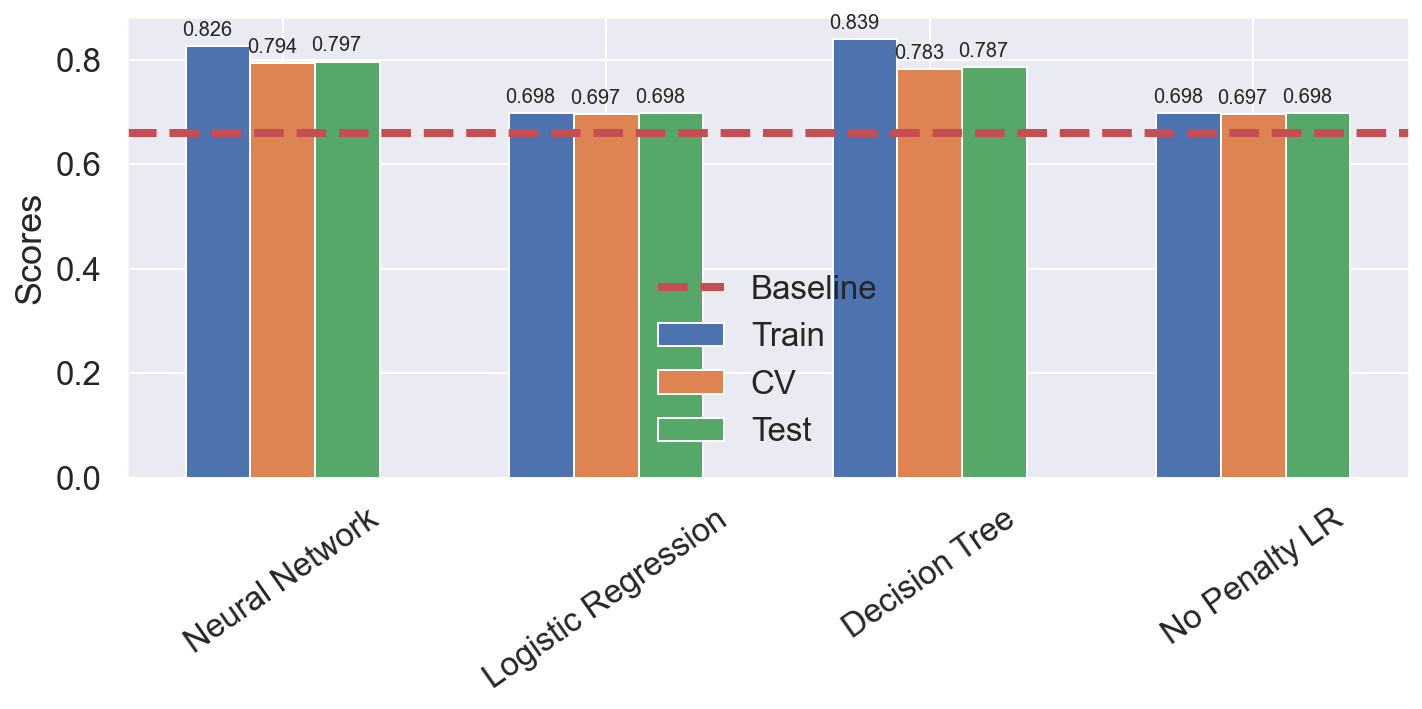

In [307]:
#Graphing the various scores (code basically repeated from earlier graph)

labels = ['Neural Network', 'Logistic Regression', 'Decision Tree', 'No Penalty LR']
models= [mlpc, lrc, dtc, npc]
trainscores = [x[0] for x in models]
cvscores= [x[1] for x in models]
testscores = [x[2] for x in models]


x = np.arange(len(labels))  # the label locations
width = 0.2# the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width, trainscores, width, label='Train')
rects2 = ax.bar(x, cvscores, width, label='CV')
rects3 = ax.bar(x + width, testscores, width, label='Test')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=35)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = np.round(rect.get_height(),3)
        if height>0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
        else:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(0, -9), 
                        textcoords="offset points",
                        ha='center', va='bottom')            

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
ax.axhline(y=y.mean(), color='r', linestyle='--', lw=4)


fig.tight_layout()
plt.legend(['Baseline', 'Train', 'CV', 'Test'])


plt.show()

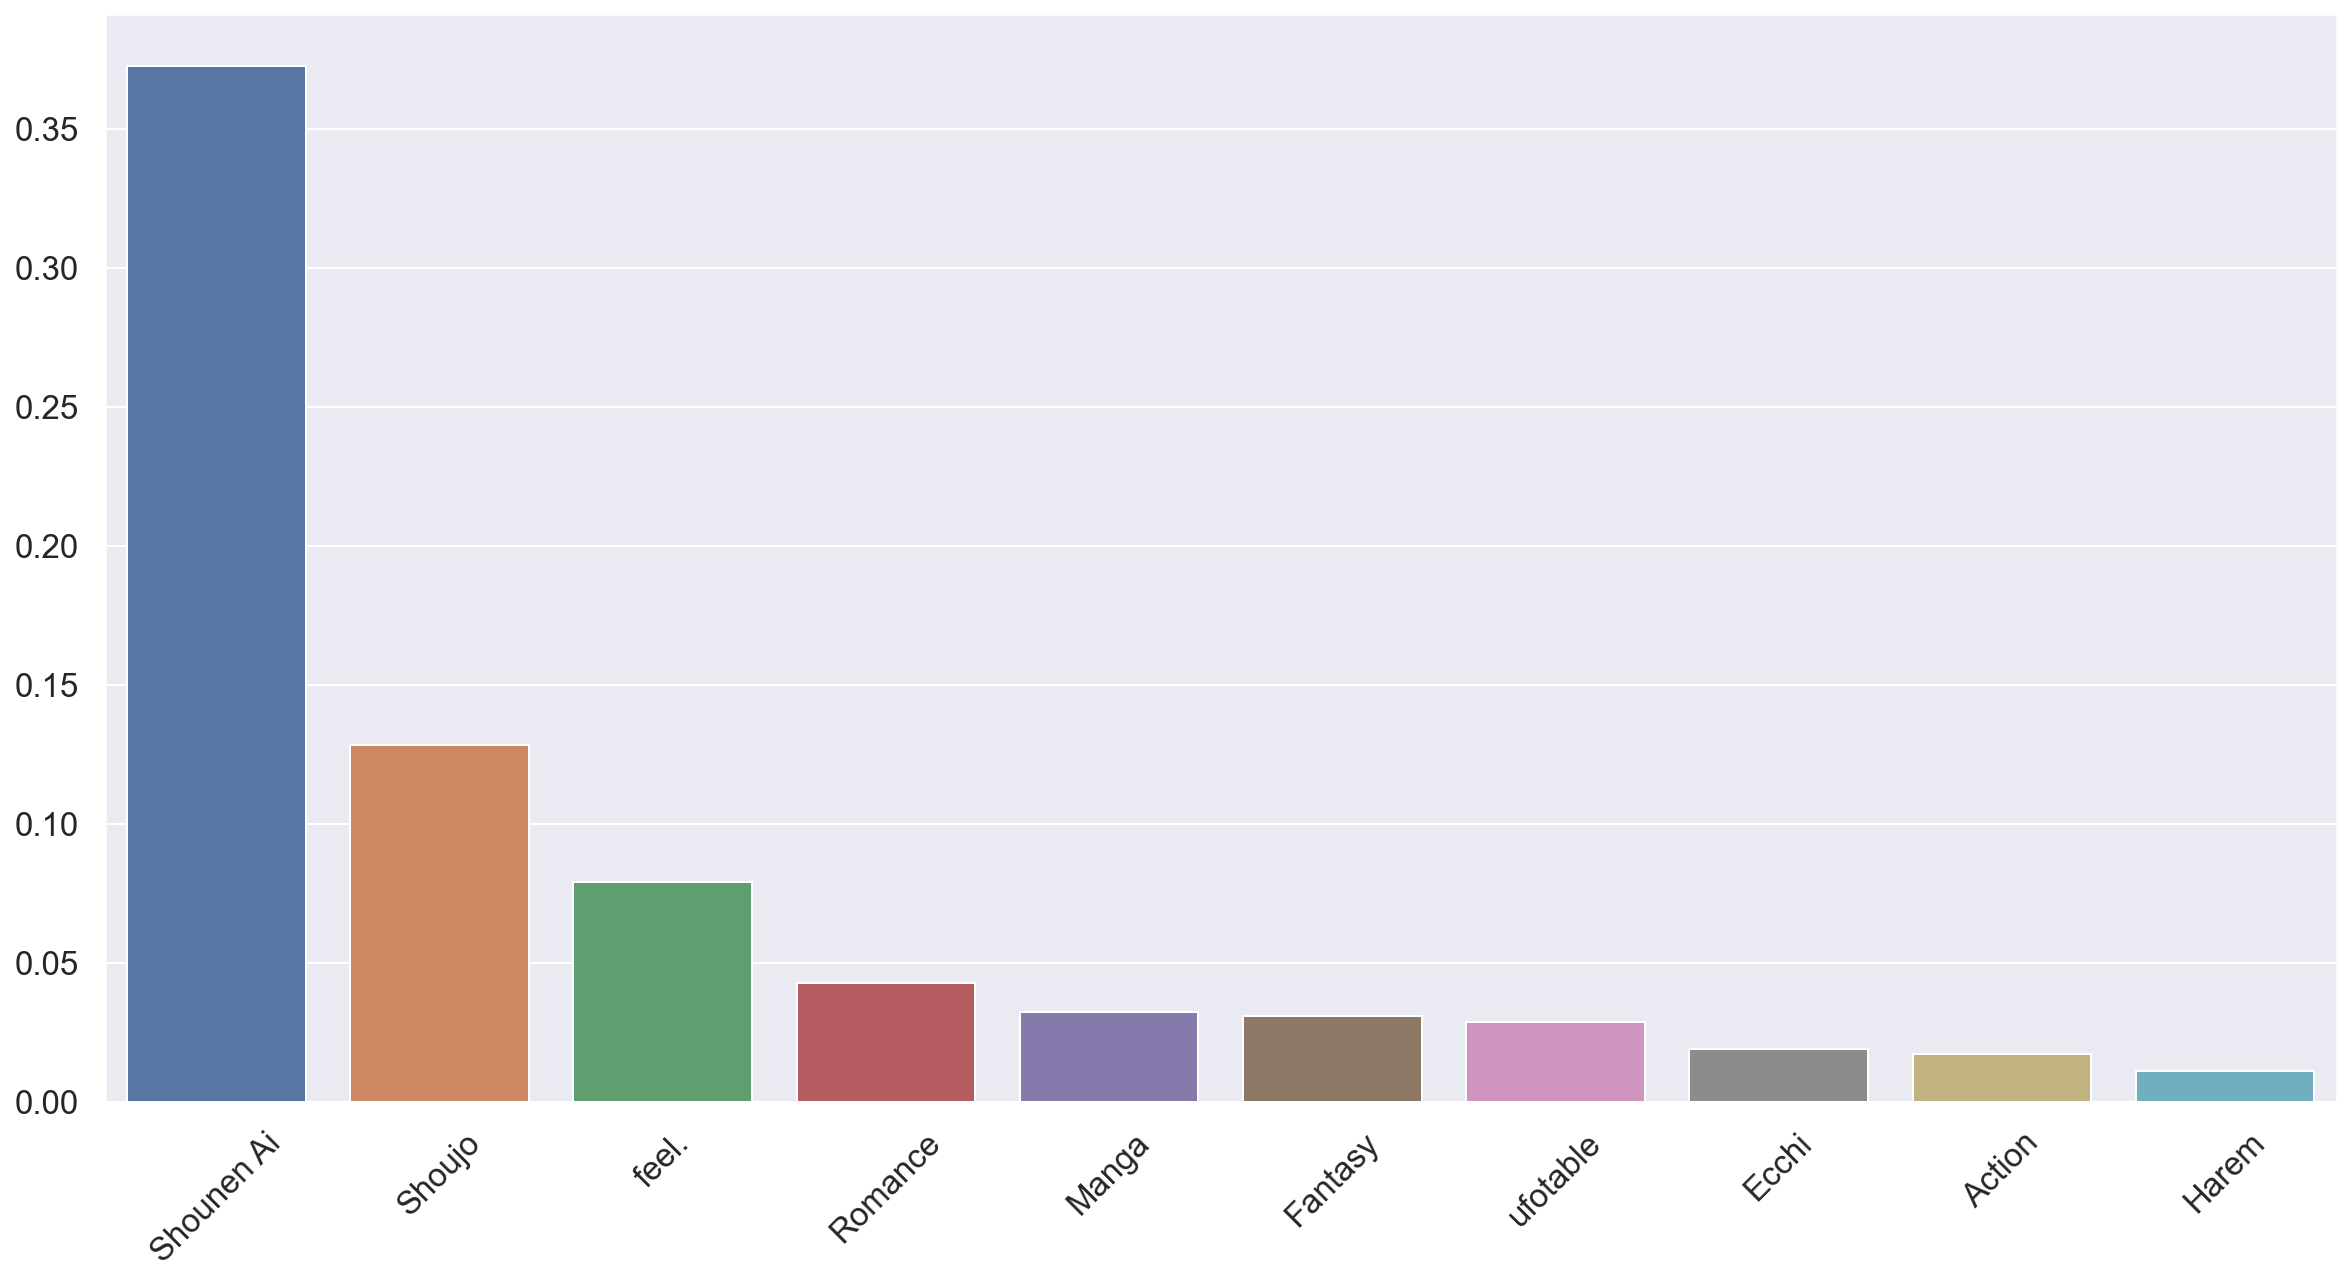

In [293]:
#plotting the most important features in the Decision Tree for comprehensibility
df= pd.DataFrame(dtc_mod.feature_importances_, index=gender_bias_df.columns)
df.columns=['coefficient']
df.sort_values('coefficient', ascending=False, inplace=True)
#Plotting the top 20 coefs
plt.figure(figsize=(20,10))
sns.barplot(df.index[:10],df.coefficient[:10])
plt.xticks(rotation=45)
plt.ylabel('');

In [ ]:
#Building the Reccomendation Engine

In [310]:
#create 10% test set in data
data_1 = sur.Dataset.load_from_df(
    data[['username', 'anime_id', 'my_score']], reader)
raw_ratings = data_1.raw_ratings
np.random.seed(177013)
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]


data_1.raw_ratings = A_raw_ratings
trainset = data_1.build_full_trainset()
trainset_build = trainset.build_testset()
testset = data_1.construct_testset(B_raw_ratings)

In [313]:
#Baseline
bo= sur.BaselineOnly()
bo.fit(trainset)
bo_predictions_train = bo.test(trainset_build)
bo_predictions_test = bo.test(testset)
print('Training score ', end='   ')
bo_train = sur.accuracy.rmse(bo_predictions_train)
bo_test = sur.accuracy.rmse(bo_predictions_test)
bo_results= [bo_train, bo_test]

#optional alert
os.system("say 'ko no di o da'") 

RMSE: 1.9585
RMSE: 1.9671


0

In [314]:
svd = sur.SVD(random_state=1,
               biased=True,  # isolate biases
               reg_all=0.1,  # use regularisation (the same for all)
               n_epochs=20,  # number of epochs for stochastic gradient descent search
               n_factors=1000,  # number of factors to retain in SVD
               verbose=True,
               )
svd.fit(trainset)
svd_predictions_train = svd.test(trainset_build)
svd_predictions_test = svd.test(testset)
print('Training score ', end='   ')
svd_train = sur.accuracy.rmse(svd_predictions_train)
svd_test = sur.accuracy.rmse(svd_predictions_test)
svd_results= [svd_train, svd_test]

#optional alert
os.system("say 'ii e senpai watshi tachi no kenka desu'") 

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Training score    RMSE: 1.5182
RMSE: 1.7467


0

In [315]:
so = sur.SlopeOne()
so.fit(trainset)
so_predictions_train = so.test(trainset_build)
so_predictions_test = so.test(testset)
print('Training score ', end='   ')
so_train = sur.accuracy.rmse(so_predictions_train)
so_test = sur.accuracy.rmse(so_predictions_test)
so_results= [so_train, so_test]

#optional alert
os.system("say 'mai waifu'") 

Training score    RMSE: 1.9423
RMSE: 1.9576


0

In [316]:
cc = sur.CoClustering()
cc.fit(trainset)
cc_predictions_train = cc.test(trainset_build)
cc_predictions_test = cc.test(testset)
print('Training score ', end='   ')
cc_train = sur.accuracy.rmse(cc_predictions_train)
cc_test = sur.accuracy.rmse(cc_predictions_test)
cc_results= [cc_train, cc_test]

#optional alert
os.system("say 'da may da neigh'") 

Training score    RMSE: 1.9243
RMSE: 1.9425


0

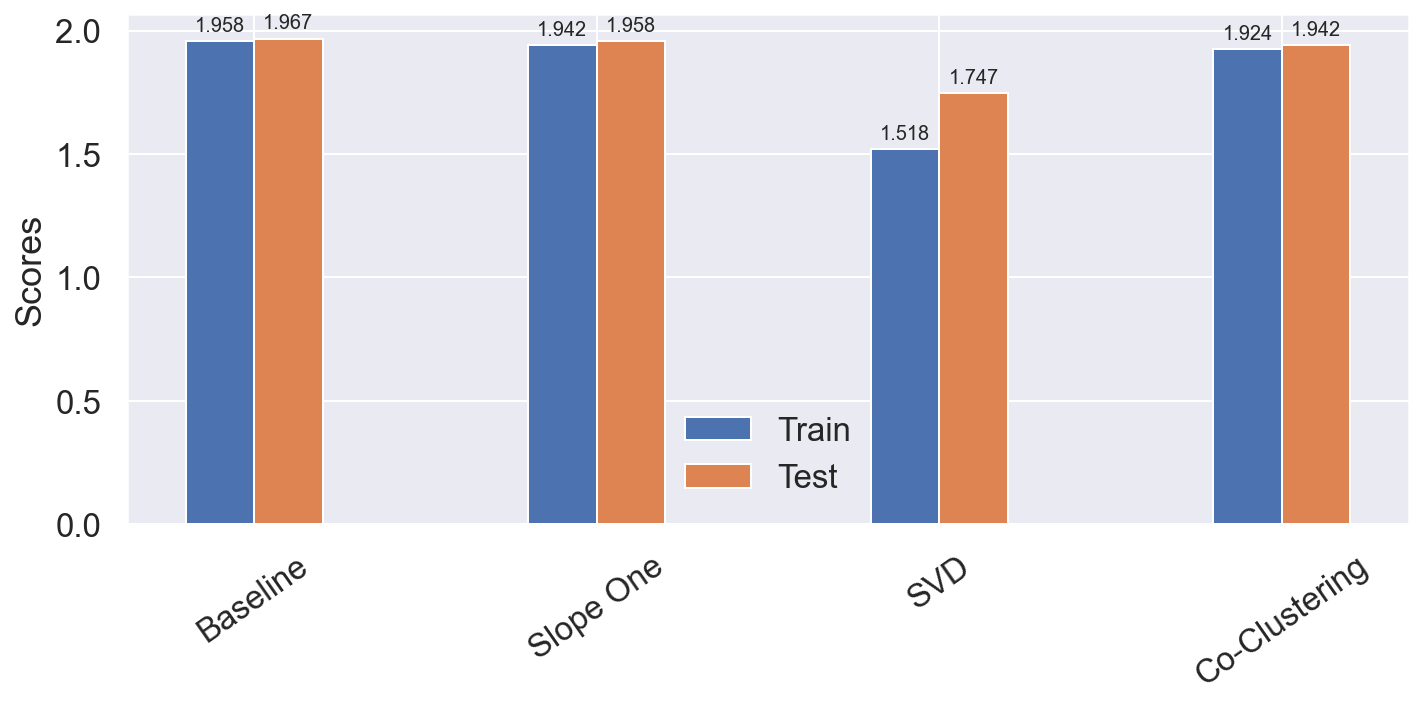

In [319]:
#Graphing the various RMSE (code again repeated)

labels = ['Baseline', 'Slope One', 'SVD', 'Co-Clustering']
models= [bo_results, so_results, svd_results, cc_results]
trainscores = [x[0] for x in models]
testscores= [x[1] for x in models]


x = np.arange(len(labels))  # the label locations
width = 0.2# the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, trainscores, width, label='Train')
rects2 = ax.bar(x + width/2, testscores, width, label='Test')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=35)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = np.round(rect.get_height(),3)
        if height>0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
        else:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -9), 
                        textcoords="offset points",
                        ha='center', va='bottom')            

autolabel(rects1)
autolabel(rects2)


fig.tight_layout()
plt.legend(['Train', 'Test'])


plt.show()

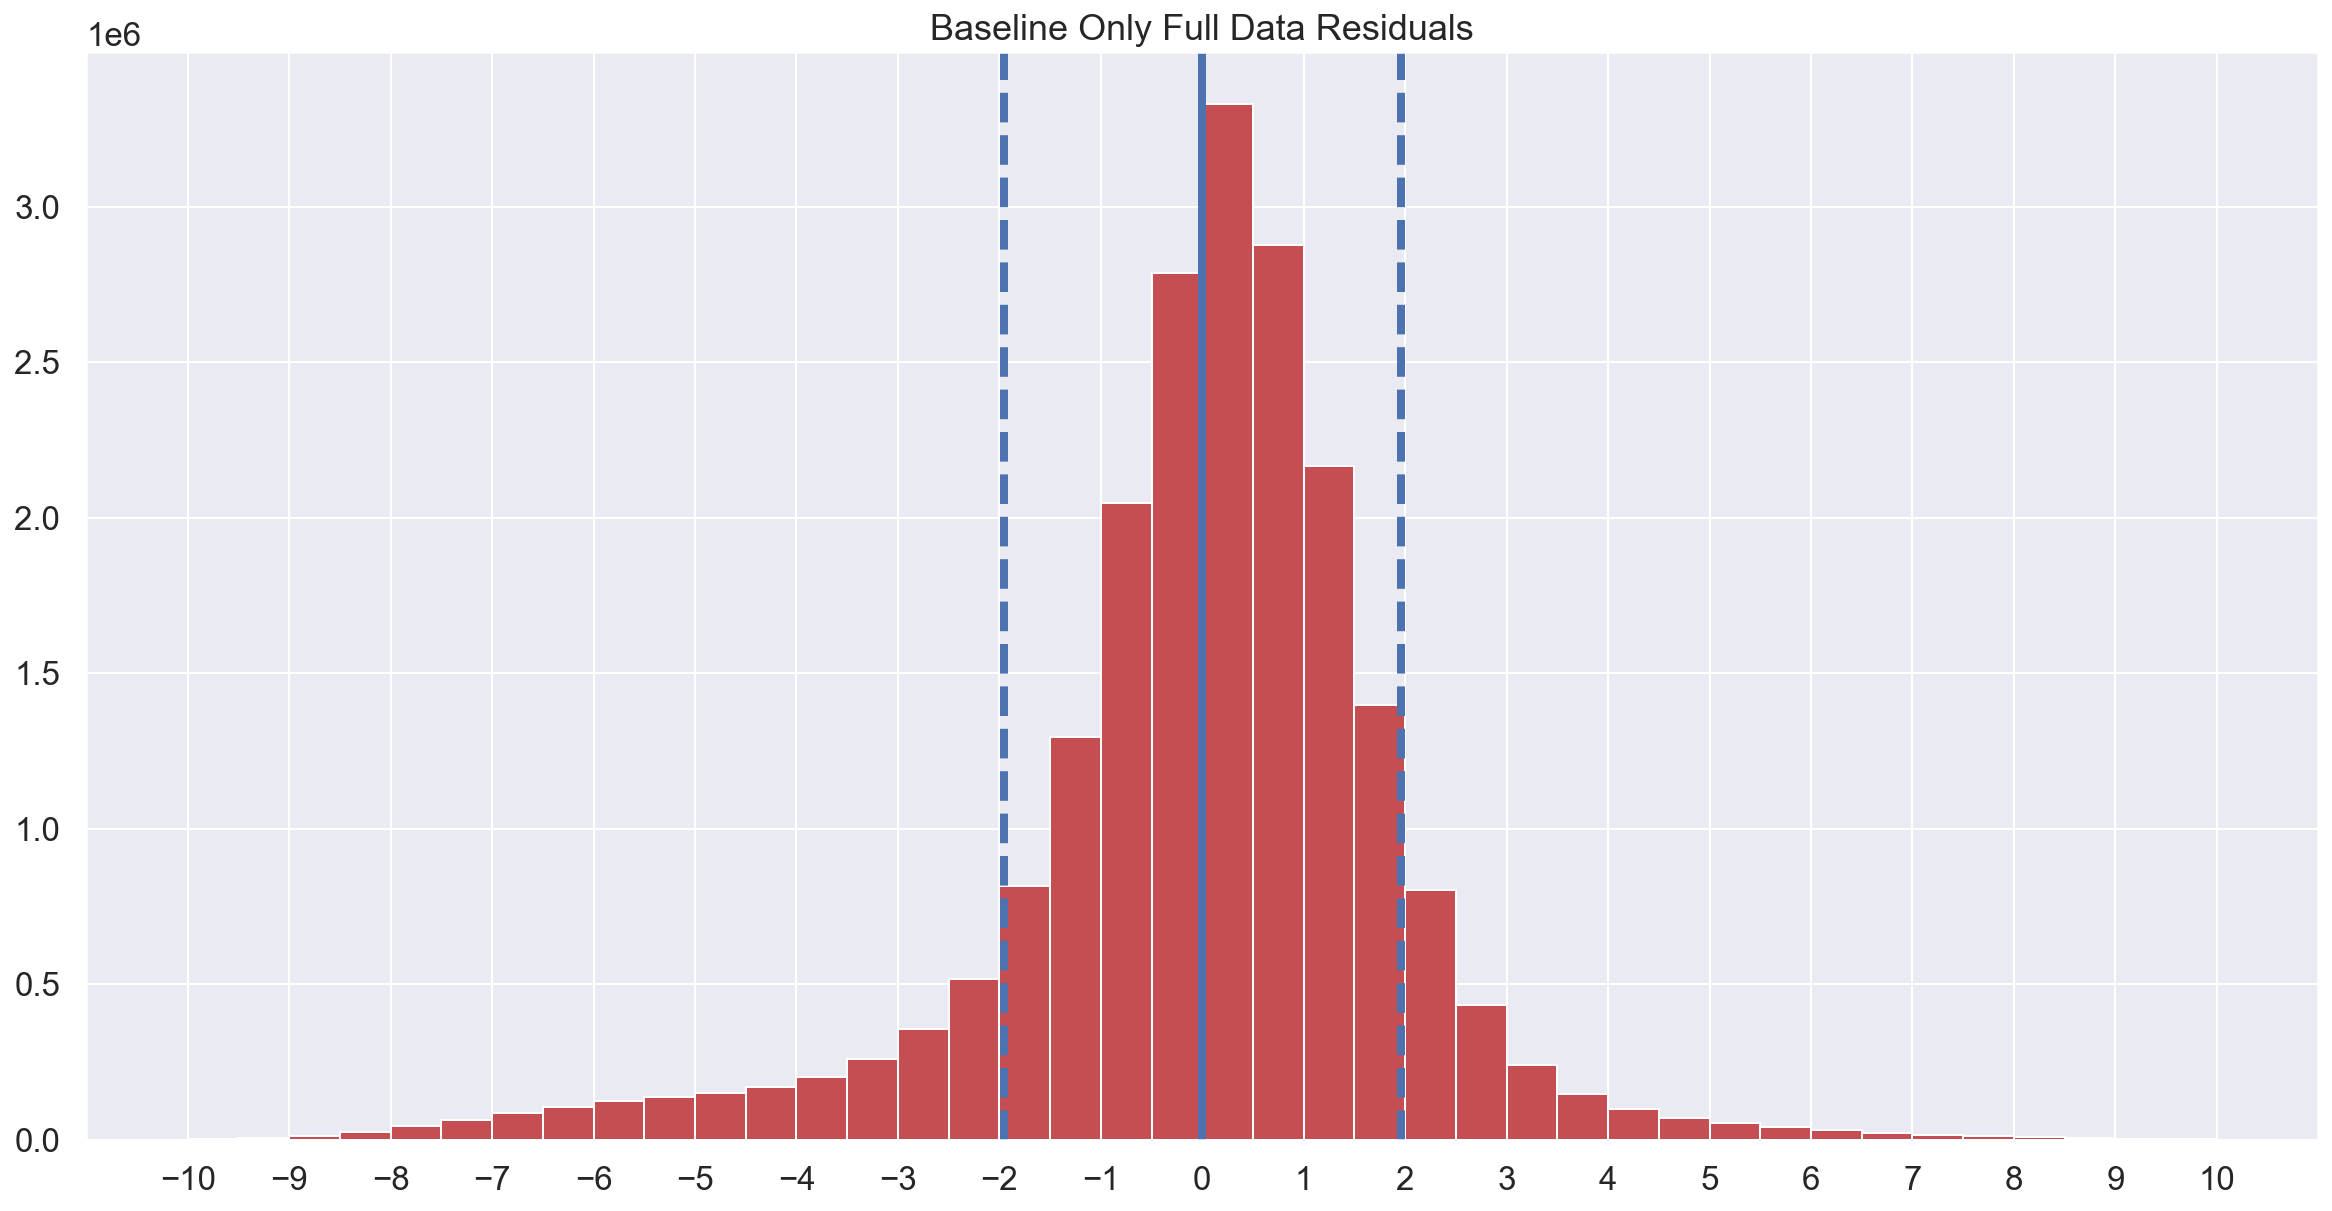

In [334]:
mean = data.unexplained_var.mean()
std = data.unexplained_var.std()

fig,ax= plt.subplots(figsize=(20,10))
plt.hist(data.unexplained_var, bins=np.linspace(-10,10,41), color='r')
plt.title('Baseline Only Full Data Residuals')

ax.axvline(x=mean, color='b', linestyle='-',lw=4)
ax.axvline(x=mean+std, color='b', linestyle='--',lw=4)
ax.axvline(x=mean-std, color='b', linestyle='--',lw=4)

plt.xticks(np.linspace(-10,10,21));

In [335]:
svd_resid = [x.r_ui - x.est for x in svd_predictions_test]

In [336]:
bo_resid =[x.r_ui - x.est for x in bo_predictions_test]

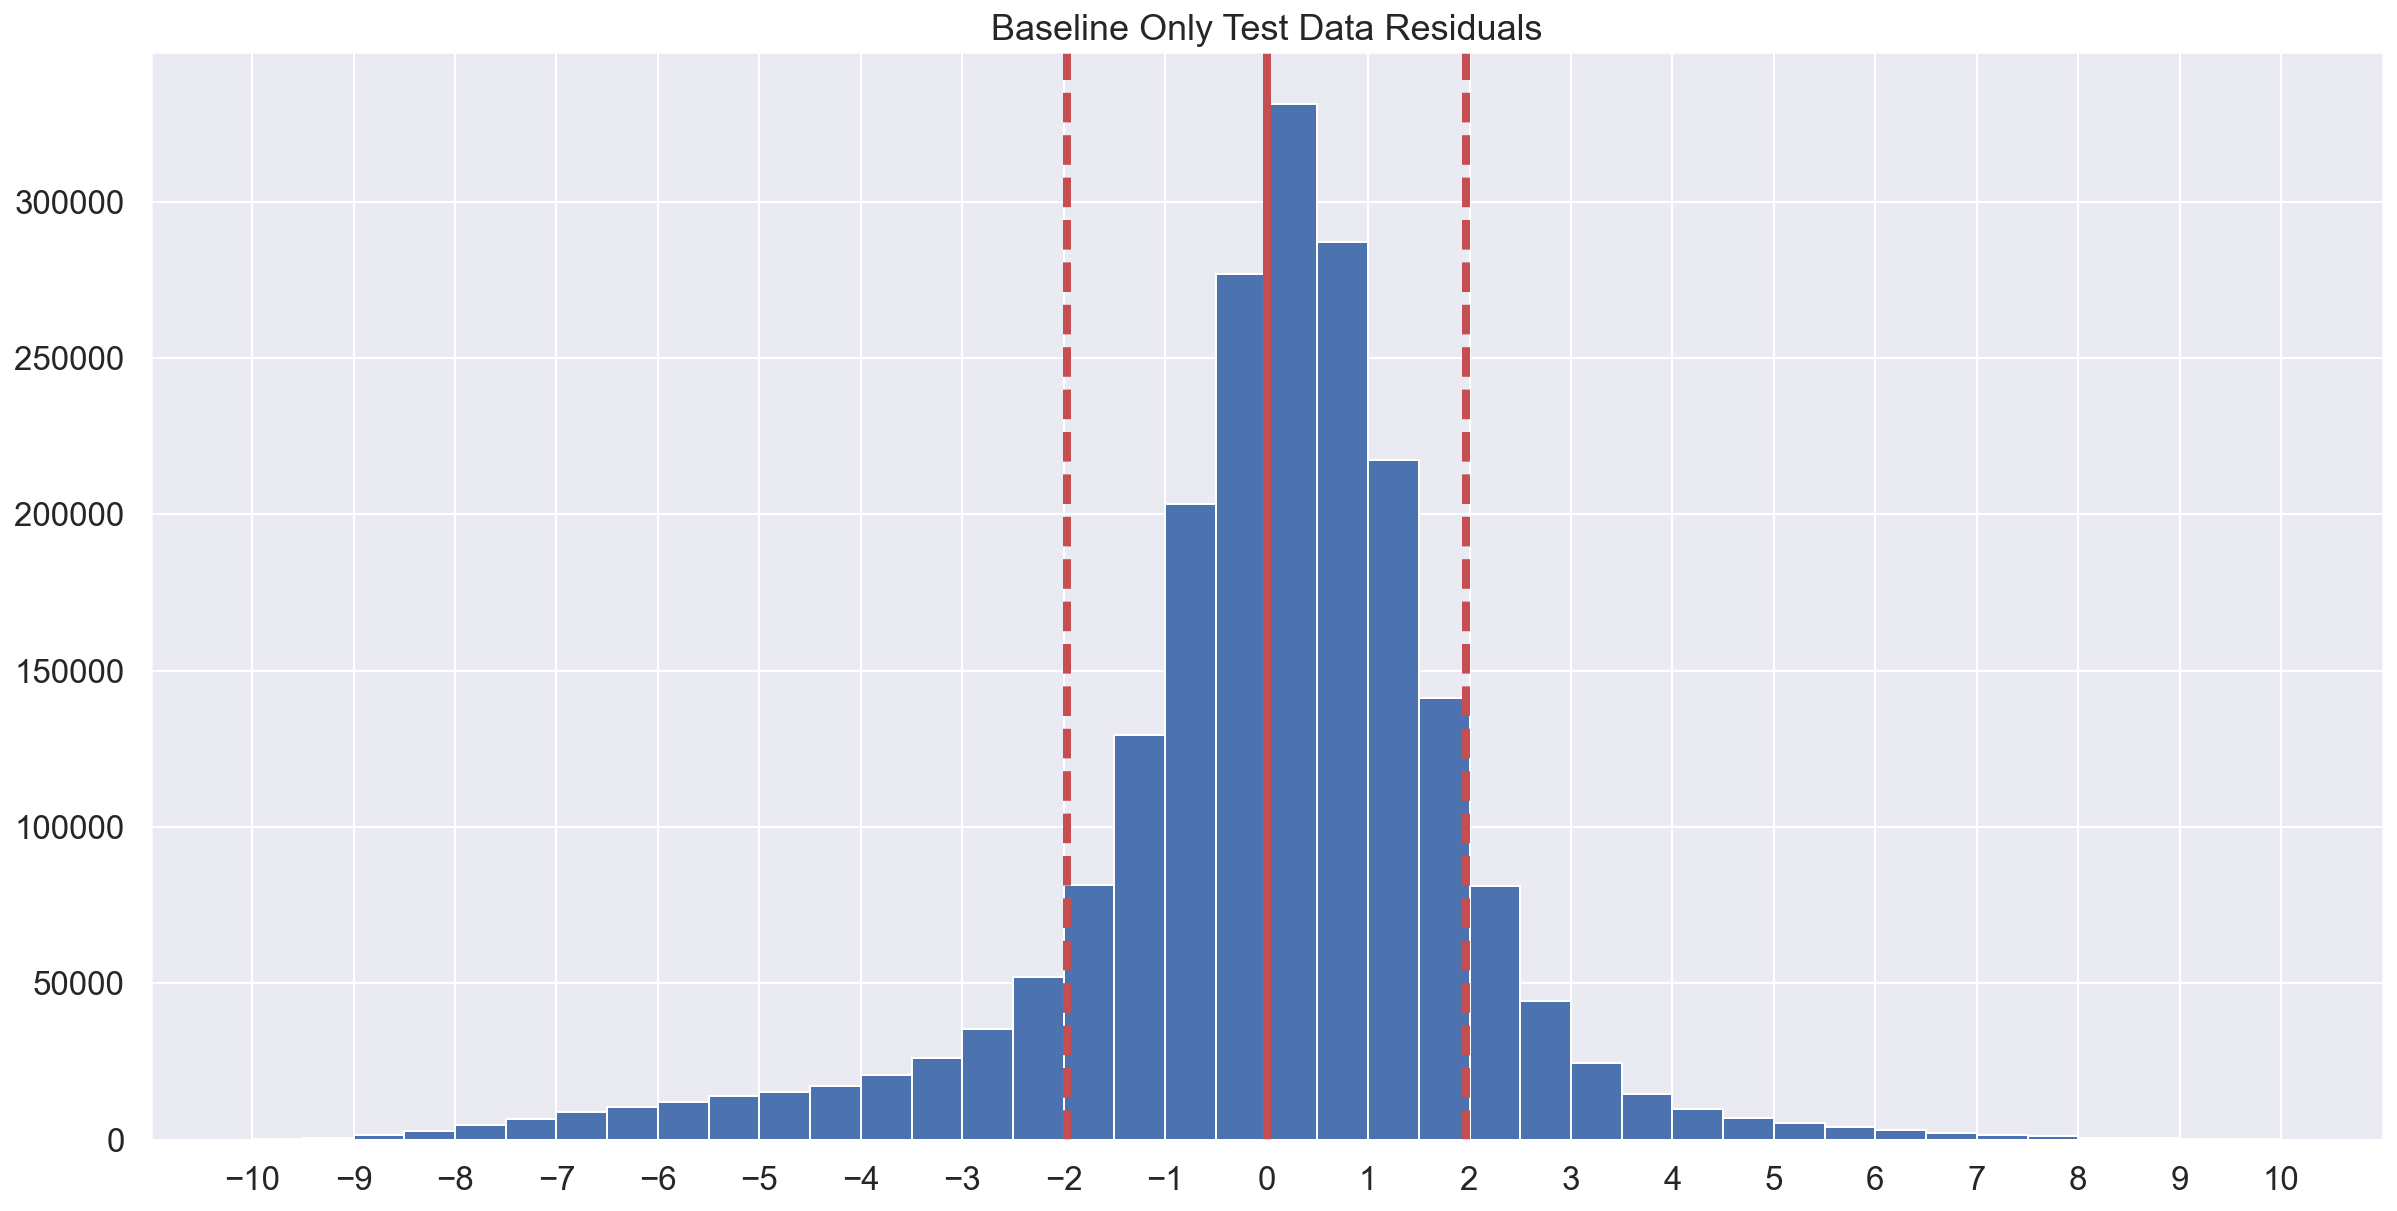

In [338]:
mean = np.mean(bo_resid)
std = np.std(bo_resid)

fig,ax= plt.subplots(figsize=(20,10))
plt.hist(bo_resid, bins=np.linspace(-10,10,41), color='b')
plt.title('Baseline Only Test Data Residuals')

ax.axvline(x=mean, color='r', linestyle='-',lw=4)
ax.axvline(x=mean+std, color='r', linestyle='--',lw=4)
ax.axvline(x=mean-std, color='r', linestyle='--',lw=4)

plt.xticks(np.linspace(-10,10,21));

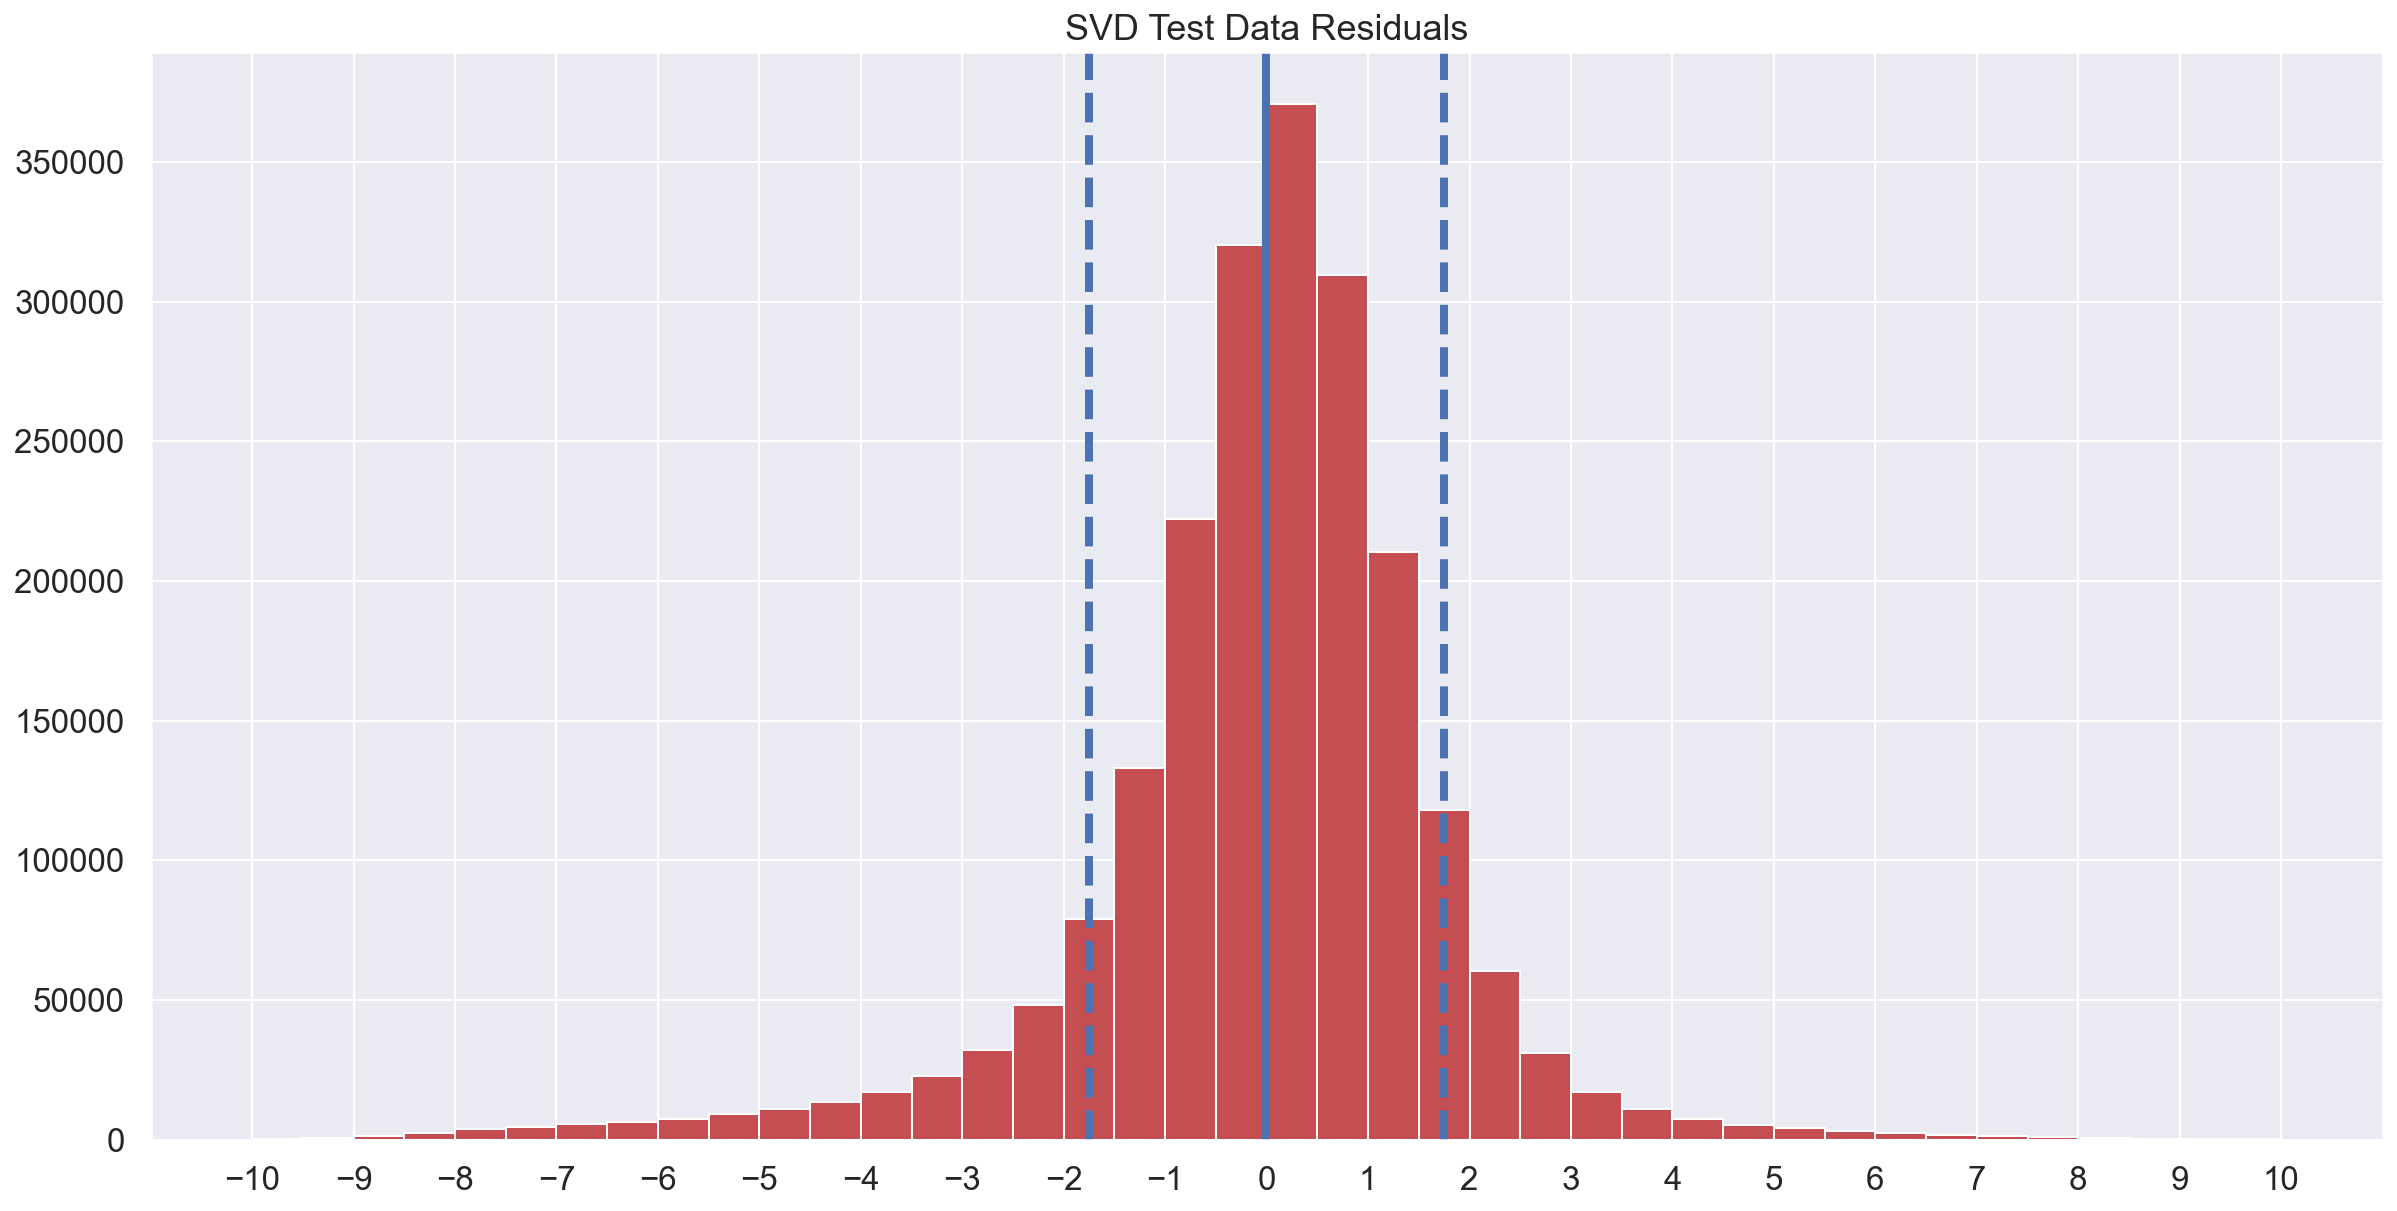

In [339]:
mean = np.mean(svd_resid)
std = np.std(svd_resid)

fig,ax= plt.subplots(figsize=(20,10))
plt.hist(svd_resid, bins=np.linspace(-10,10,41), color='r')
plt.title('SVD Test Data Residuals')

ax.axvline(x=mean, color='b', linestyle='-',lw=4)
ax.axvline(x=mean+std, color='b', linestyle='--',lw=4)
ax.axvline(x=mean-std, color='b', linestyle='--',lw=4)

plt.xticks(np.linspace(-10,10,21));